<footer id="footer"></footer>

<p align="center"><img src='https://i.ibb.co/v44WM0y/2.jpg'></p>

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. Целевая метрика `AUC-ROC` - необходимое качество - `0.88`. Дополнительная метрика `Accuracy`

---

<font size="2"> [01. Дополнительное исследование в Google Collab](https://colab.research.google.com/drive/1tqfUYXUD_hZ8yIVujrrxvx9o8zvAhZTr?usp=sharing)   
[02. Дипломный проект в Google Collab](https://colab.research.google.com/drive/1t7b-GyHxO9IEYNmcgQUgWrZlWTtOGj6O?usp=sharing)</font>

---
    
 <font size="1"> **Примечание:** *для удобства чтения работы длинные выводы работы кода были закрыты* </font>



## Загрузка данных и первичный осмотр

### Импорт необходимых библиотек

In [ ]:
%%capture
!pip install catboost

In [ ]:
%%capture
!pip install xgboost

In [ ]:
%%capture
!pip install shap

In [ ]:
%%capture
!pip install optuna

In [ ]:
%%capture
!pip install -U keras-tuner

In [ ]:
%%capture
!pip install hyperopt

In [ ]:
%%capture
!pip install phik

In [ ]:
import pandas as pd
import numpy as np 
import pylab
import scipy.stats as stats
import warnings
import optuna
import shap
import time
import hyperopt

import pickle
import phik
from phik.report import plot_correlation_matrix
from phik import report

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight, shuffle
from sklearn.feature_selection import mutual_info_classif
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

from keras_tuner.tuners import RandomSearch
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K


from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Nadam

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from catboost import Pool

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")
np.random.seed(42)

In [ ]:
%%capture
!gdown --id 1f6D0-zvQOqmwMCQSF8fqwRtmfXchND9E
!unzip /content/final_provider.zip

In [ ]:
try:
  contract = pd.read_csv('/content/final_provider/contract.csv')
  internet = pd.read_csv('/content/final_provider/internet.csv')
  personal = pd.read_csv('/content/final_provider/personal.csv')
  phone = pd.read_csv('/content/final_provider/phone.csv')
except:
  contract = pd.read_csv('/datasets/final_provider/contract.csv')
  internet = pd.read_csv('/datasets/final_provider/internet.csv')
  personal = pd.read_csv('/datasets/final_provider/personal.csv')
  phone = pd.read_csv('/datasets/final_provider/phone.csv')

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

## Загрузка данных. Осмотр и обработка. Первичный анализ

В работе 4 сета данных. Ускорим просмотр основной информации через функцию

In [ ]:
def get_info(data):
    display(data.head())
    display(data.describe().T)
    print('----')
    print('Информация о пропусках и типах данных')
    print('----')
    print()
    display(data.info())
    print('----')
    print()

#### Контракты

Рассмотрим сет данных, содержащих информацию о контрактах, заключенных с компанией на обслуживание

In [ ]:
get_info(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


----
Информация о пропусках и типах данных
----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

----



In [ ]:
contract['customerID'].nunique()

7043

In [ ]:
contract['customerID'].duplicated().sum()

0

In [ ]:
contract.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

**Вывод по contract.csv**

Имеем 7 признаков: `customerID`, `BeginDate`, `EndDate`, `Type`, `PaperlessBilling`, `PaymentMethod`, `MonthlyCharges`, `TotalCharges`



- `contract.csv` — содержит информацию о договоре;  
Пропусков нет, дубликатов тоже. Пользователи уникальны, их количество соответствует количество объектов выборки.  
  -- `customerID` - содержит информацию о пользователе. его идентификационном номере в системе
  -- `BeginDate` - содержит информацию о дате начала пользования услугами  
  -- `EndDate` - содержит информацию о дате окончания пользования услугами, может служить маркером оттока - необходимо уточнение и дополнительная проверка - у нас есть информация, что данные актуальны на 01 февраля 2020 года  
  -- `Type` - содержит информацию о типе подписки  
  -- `PaperlessBilling` - содержит информацию о типе выставления счета  
  -- `PaymentMethod` - содержит информацию о способе оплаты  
  -- `MonthlyCharges` - содержит информацию о сумме помесячной оплаты  
  -- `TotalCharges` - содержит информацию об итоговой оплате от клиента  


- `BeginDate` необходимо привести к типу данных datetime  
- `TotalCharges` необходимо привести к float  

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

#### Интернет

In [ ]:
get_info(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,count,unique,top,freq
customerID,5517,5517,5337-IIWKZ,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


----
Информация о пропусках и типах данных
----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

----



In [ ]:
internet['customerID'].nunique()

5517

In [ ]:
internet.duplicated().sum()

0

**Вывод по internet.csv**

Имеем 7 признаков: `customerID`, `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`



- `internet.csv` — информация об интернет-услугах;  
Пропусков нет, дубликатов тоже. Пользователи уникальны, их количество соответствует количество объектов выборки.  
  -- `customerID` - содержит информацию о пользователе. его идентификационном номере в системе
  -- `InternetService` - содержит информацию о том пользуется пользователь услугами Интернет или нет  
  -- `OnlineSecurity` - подключена ли услуга блокировки опасных сайтов  
  -- `OnlineBackup` - подключено ли облачное хранилище файлов для резервного копирования данных   
  -- `DeviceProtection` - наличие антивируса  
  -- `TechSupport` - выделенная линия с технической поддержкой    
  -- `StreamingTV` - наличие стримингового телевидения  
  -- `StreamingMovies` - наличие дополнительного каталога фильмов  


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

#### Персональная информация

In [ ]:
get_info(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0


----
Информация о пропусках и типах данных
----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

----



In [ ]:
personal['customerID'].nunique()

7043

In [ ]:
personal['customerID'].duplicated().sum()

0

In [ ]:
personal.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

**Вывод по personal.csv**

Имеем 5 признаков: `customerID`, `gender`, `SeniorCitizen`, `Partner`, `Dependents`



- `personal.csv` — персональная информация пользователей;  
Пропусков нет, дубликатов тоже. Пользователи уникальны, их количество соответствует количество объектов выборки.  
  -- `customerID` - содержит информацию о пользователе. его идентификационном номере в системе  
  -- `gender` - пол  
  -- `SeniorCitizen` - пенсионер. Тип данных int64 необходимо перевести в object или category  
  -- `Partner` - находится в официальных отношениях   
  -- `Dependents` - иждевенец   



<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

#### Пользование телефонией

In [ ]:
get_info(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,count,unique,top,freq
customerID,6361,6361,6698-OXETB,1
MultipleLines,6361,2,No,3390


----
Информация о пропусках и типах данных
----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

----



- `phone.csv` — информация об услугах телефонии.

In [ ]:
phone['customerID'].nunique()

6361

In [ ]:
phone['customerID'].duplicated().sum()

0

**Вывод по phone.csv**

Имеем 2 признака: `customerID`, `MultipleLines`



- `phone.csv` — информация о пользовании телефоном;  
Пропусков нет, дубликатов тоже. Пользователи уникальны, их количество соответствует количество объектов выборки.  
  -- `customerID` - содержит информацию о пользователе. его идентификационном номере в системе  
  -- `MultipleLines` - подключен к нескольким линиям




<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

#### Объединение данных и предварительная обработка

Пользователи уникальны, повтором нет - 1 строка - 1 пользователь. Загрузим сеты снова, указав индекс по пользователю и проведем объединение таблиц. Дальнейшую обработку будем проводить на обобщенных данных. при повторной обработке - загружать данные будем через `pipe`. Сейчас, для сохранения целостности проекта - перезапишем в качестве исключения

In [ ]:
try:
  contract = pd.read_csv('/content/final_provider/contract.csv', index_col='customerID')
  internet = pd.read_csv('/content/final_provider/internet.csv', index_col='customerID')
  personal = pd.read_csv('/content/final_provider/personal.csv', index_col='customerID')
  phone = pd.read_csv('/content/final_provider/phone.csv', index_col='customerID')
except:
  contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
  internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
  personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
  phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')

In [ ]:
df = contract.join([internet, personal, phone], how='left')

In [ ]:
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


Сбросим индекс, колонки преобразуем - привдем к нижнему регистру и добавим snake-case для нашего удобства

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df.columns = df.columns.str.lower()

In [ ]:
df.columns

Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'gender', 'seniorcitizen', 'partner',
       'dependents', 'multiplelines'],
      dtype='object')

In [ ]:
df.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [ ]:
df.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'gender', 'senior_citizen', 'partner', 'dependents',
       'multiple_lines']
df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines'],
      dtype='object')

In [ ]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   internet_service   5517 non-null   object 
 9   online_security    5517 non-null   object 
 10  online_backup      5517 non-null   object 
 11  device_protection  5517 non-null   object 
 12  tech_support       5517 non-null   object 
 13  streaming_tv       5517 non-null   object 
 14  streaming_movies   5517 non-null   object 
 15  gender             7043 non-null   object 
 16  senior_citizen     7043 

У нас наблюдаются пропуски - таблицы были разнородные, с отличным друг от друга количеством строк. Отсутствие записи - воспринимаем как отсутсвие услуги. Дальнейшую обработку буду производить исходя из того факта, что отсутствие записи это признак отсутсвия подписки - `No`

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

#### Замена типов данных

`total_charges` необходимо перевести в float64, так как он содержит в себе общие поступления от конкретного пользователя. Проверим, есть пустые строки без записи

In [ ]:
df.loc[df['total_charges'] == ' ', 'total_charges'].count()

11

Заменим их на 0 - возможно пропуски связаны с тем фактом, что у клиент еще не оплачивал - пользуется бесплатным временем

In [ ]:
df.loc[df['total_charges'] == ' ', 'total_charges'] = df['monthly_charges']
df['total_charges'] = df['total_charges'].astype('float64')

Признак `senior_citizen` значится как int64 по типу - необходимо посмотреть значения. Скорее всего - нам надо преобразовать его в object или category

In [ ]:
df['senior_citizen'].value_counts()

0    5901
1    1142
Name: senior_citizen, dtype: int64

Наше предположение верное - признак `senior_citizen` необходимо преобразовать в `category`. Также поменяем тип данных в признаке `begin_date`

In [ ]:
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')
df['senior_citizen'] = df['senior_citizen'].astype('category')

#### Обработка end_date

Вынесем обработку данного признака как отдельный пункт нашей работы - это признак ухода

In [ ]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


Посмотрим на значения, которые формируют данный признак

In [ ]:
df['end_date'].value_counts(normalize=True)

No                     0.734630
2019-11-01 00:00:00    0.068863
2019-12-01 00:00:00    0.066165
2020-01-01 00:00:00    0.065313
2019-10-01 00:00:00    0.065029
Name: end_date, dtype: float64

In [ ]:
df['end_date_02_20'] = df['end_date'].apply(lambda x: '2020-02-01 00:00:00' if x =='No' else x)
df['end_date_02_20'] = pd.to_datetime(df['end_date_02_20'], format='%Y-%m-%d %S:%M:%H')
df['total_days'] = (df['end_date_02_20'] - df['begin_date']).astype('timedelta64[D]')
df['total_days'] = df['total_days'].astype('int64')

Исхожу из того, что для признака `end_date` - наличие даты является маркером оттока - преобразую столбец, заменив значения на 0 и 1 - **1 ставим как маркер оттока**

In [ ]:
df['label'] = np.where(df['end_date'] == 'No', 0, 1).astype('object')

In [ ]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,end_date_02_20,total_days,label
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN,2020-02-01,31,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,2020-02-01,1036,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,2019-12-01,61,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN,2020-02-01,1371,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,2019-11-01,61,1


Таким образом выделили целевой признак. 

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

#### Обработка пропусков

In [ ]:
(df.isna().mean().sort_values(ascending=False)
.to_frame('Nan').style.set_caption('Данные по пропускам')
.set_precision(2).background_gradient(low=0.42))
 

,Nan
device_protection,0.22
streaming_movies,0.22
streaming_tv,0.22
tech_support,0.22
online_backup,0.22
online_security,0.22
internet_service,0.22
multiple_lines,0.10
total_charges,0.00
begin_date,0.00


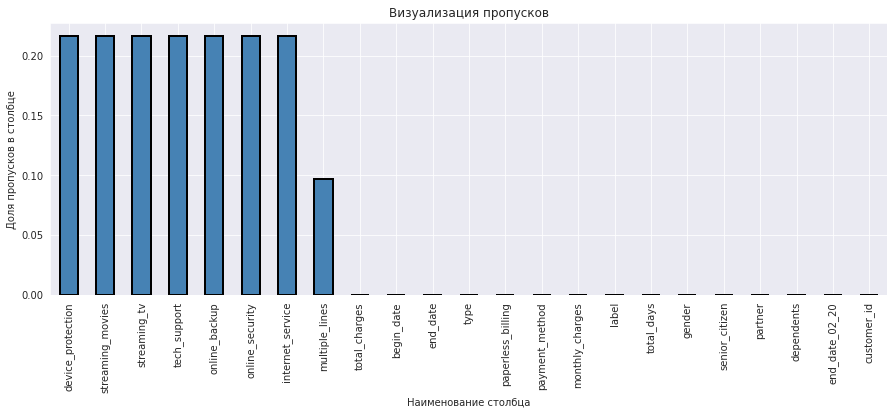

In [ ]:
df.isna().mean().sort_values(ascending=False).plot(
    kind='bar', figsize=(15,5), 
    grid=True, color='steelblue', 
    edgecolor='black', linewidth=2
)
plt.title('Визуализация пропусков')
plt.xlabel('Наименование столбца')
plt.ylabel('Доля пропусков в столбце')
plt.show()

Для того, чтобы понять как их заменить - посмотрим что за значения встречаются в разных признаках

In [ ]:
cols = ['online_security', 'tech_support', 'internet_service', 'online_backup', 
        'device_protection', 'streaming_movies', 'streaming_tv', 'multiple_lines']

In [ ]:
for col in cols:
  print(f'Признак {col}', '\n', df[col].value_counts(normalize=True, 
                                                     dropna=False))
  print('------------------------')

Признак online_security 
 No     0.496663
Yes    0.286668
NaN    0.216669
Name: online_security, dtype: float64
------------------------
Признак tech_support 
 No     0.493114
Yes    0.290217
NaN    0.216669
Name: tech_support, dtype: float64
------------------------
Признак internet_service 
 Fiber optic    0.439585
DSL            0.343746
NaN            0.216669
Name: internet_service, dtype: float64
------------------------
Признак online_backup 
 No     0.438450
Yes    0.344881
NaN    0.216669
Name: online_backup, dtype: float64
------------------------
Признак device_protection 
 No     0.439443
Yes    0.343888
NaN    0.216669
Name: device_protection, dtype: float64
------------------------
Признак streaming_movies 
 No     0.395428
Yes    0.387903
NaN    0.216669
Name: streaming_movies, dtype: float64
------------------------
Признак streaming_tv 
 No     0.398978
Yes    0.384353
NaN    0.216669
Name: streaming_tv, dtype: float64
------------------------
Признак multiple_lines 
 

Будем исходить из того факта, что отсутсвие записи - есть признак отсутствия услуги - для заменим на `No`

In [ ]:
df[cols] = df[cols].fillna('No')

In [ ]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,end_date_02_20,total_days,label
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No,2020-02-01,31,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,2020-02-01,1036,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,2019-12-01,61,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,No,2020-02-01,1371,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,2019-11-01,61,1


Посмотрим значения оставшихся признаков

In [ ]:
cols_to_check = list(set(df.columns) - set(cols) - set(['begin_date', 'total_charges',  
                                     'monthly_charges', 'customer_id']))

In [ ]:
cols_to_check

['total_days',
 'type',
 'partner',
 'payment_method',
 'senior_citizen',
 'paperless_billing',
 'dependents',
 'gender',
 'end_date_02_20',
 'end_date',
 'label']

In [ ]:
for col in cols_to_check:
  print(f'Признак {col}', '\n', df[col].value_counts(normalize=True, 
                                                     dropna=False))
  print('------------------------')

Признак total_days 
 31      0.061196
2191    0.051399
30      0.025841
92      0.023995
2163    0.023286
          ...   
1552    0.000284
2068    0.000284
1369    0.000284
1917    0.000142
2161    0.000142
Name: total_days, Length: 156, dtype: float64
------------------------
Признак type 
 Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: type, dtype: float64
------------------------
Признак partner 
 No     0.516967
Yes    0.483033
Name: partner, dtype: float64
------------------------
Признак payment_method 
 Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: payment_method, dtype: float64
------------------------
Признак senior_citizen 
 0    0.837853
1    0.162147
Name: senior_citizen, dtype: float64
------------------------
Признак paperless_billing 
 Yes    0.592219
No     0.407781
Name: paperless_billing, dtype: float64
--------------

Признаки категориальные, будем кодировать в будущем - `OrdinalEncoder` для порядковых и `Ohe` для бинарных

Избавимся от признака `customer_id`

In [ ]:
df.drop('customer_id', inplace=True, axis=1)

**Вывод**

- обработали пропуски - Заменили значение на `No` - в дальнейшем при моделировании будем кодировать
- выделили целевой признак `label`

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

#### Pipe обработка данных

<a id='Pipe'></a>

Для ускорения работы в дальнейшем - сделаем преподготовку в виде pipe методов
Для этого перезапишем переменные сетов и загрузим их снова - чтобы продесмонстрировать эффективность данного подхода - в будущем это может сэкономить время. Подготовку сделаем через очередь методов

In [ ]:
try:
  contract = pd.read_csv('/content/final_provider/contract.csv', index_col='customerID')
  internet = pd.read_csv('/content/final_provider/internet.csv', index_col='customerID')
  personal = pd.read_csv('/content/final_provider/personal.csv', index_col='customerID')
  phone = pd.read_csv('/content/final_provider/phone.csv', index_col='customerID')
except:
  contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
  internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
  personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
  phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')

In [ ]:
df_pred = contract.join([internet, personal, phone], how='left')

In [ ]:
def col_name(data):
  data.reset_index(inplace=True)
  data.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'gender', 'senior_citizen', 'partner', 'dependents',
       'multiple_lines']
  return data

def change_types_and_label(data):
  data.loc[data['total_charges'] == ' ', 'total_charges'] = data['monthly_charges']
  data['total_charges'] = data['total_charges'].astype('float64')
  data['begin_date'] = pd.to_datetime(data['begin_date'], format='%Y-%m-%d')
  data['senior_citizen'] = data['senior_citizen'].astype('category')
  data['label'] = np.where(data['end_date'] == 'No', 0, 1).astype('int64')
  # дополнительный признак лояльности - платят на год вперед - далее в анализе
  data['loyality'] =  data['type'].apply(lambda x: 0 if x == 'Month-to-month' else 1).astype('category')

  return data

def fillnan(data):
  cols = ['online_security', 'tech_support', 'internet_service', 'online_backup', 
        'device_protection', 'streaming_movies', 'streaming_tv', 'multiple_lines']
  data[cols] = data[cols].fillna('No')
  data['internet_service'] = data['internet_service'].apply(lambda x: 0 if x == 'No' else 1).astype('category')
  return data

def chaneg_new_features(data):
  data['end_date_02_20'] = data['end_date'].apply(lambda x: '2020-02-01 00:00:00' if x =='No' else x)
  data['end_date_02_20'] = pd.to_datetime(data['end_date_02_20'], format='%Y-%m-%d %S:%M:%H')
  data['total_days'] = (data['end_date_02_20'] - data['begin_date']).astype('timedelta64[D]')
  data['total_days'] = data['total_days'].astype('int64')
  return data

 
def drop_cols(data):
  cols = ['customer_id', 'begin_date', 'end_date', 'end_date_02_20']
  data.drop(cols, inplace=True, axis=1)
  return data

In [ ]:
prep_df = (df_pred
    .pipe(col_name)
    .pipe(change_types_and_label)
    .pipe(fillnan)
    .pipe(chaneg_new_features)
    .pipe(drop_cols)
)

In [ ]:
prep_df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,label,loyality,total_days
0,Month-to-month,Yes,Electronic check,29.85,29.85,1,No,Yes,No,No,No,No,Female,0,Yes,No,No,0,0,31
1,One year,No,Mailed check,56.95,1889.50,1,Yes,No,Yes,No,No,No,Male,0,No,No,No,0,1,1036
2,Month-to-month,Yes,Mailed check,53.85,108.15,1,Yes,Yes,No,No,No,No,Male,0,No,No,No,1,0,61
3,One year,No,Bank transfer (automatic),42.30,1840.75,1,Yes,No,Yes,Yes,No,No,Male,0,No,No,No,0,1,1371
4,Month-to-month,Yes,Electronic check,70.70,151.65,1,No,No,No,No,No,No,Female,0,No,No,No,1,0,61


In [ ]:
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               7043 non-null   object  
 1   paperless_billing  7043 non-null   object  
 2   payment_method     7043 non-null   object  
 3   monthly_charges    7043 non-null   float64 
 4   total_charges      7043 non-null   float64 
 5   internet_service   7043 non-null   category
 6   online_security    7043 non-null   object  
 7   online_backup      7043 non-null   object  
 8   device_protection  7043 non-null   object  
 9   tech_support       7043 non-null   object  
 10  streaming_tv       7043 non-null   object  
 11  streaming_movies   7043 non-null   object  
 12  gender             7043 non-null   object  
 13  senior_citizen     7043 non-null   category
 14  partner            7043 non-null   object  
 15  dependents         7043 non-null   object  
 16  multip

Таким образом, при повторении исследования - можно быстро получить сет для работы - `object` или `category` к одному формату приводить не стали - нет необходимости - данные будут загружаться в модель через `Pipeline`

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

## Исследовательский анализ данных

### Признаки monthly_charges и total_charges

Отдельно расммотрим признаки, которые отвечают за платежи клиентов - `monthly_charges` и `total_charges`

In [ ]:
df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,end_date_02_20,total_days,label
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No,2020-02-01,31,0
1,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,2020-02-01,1036,0
2,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,2019-12-01,61,1
3,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,No,2020-02-01,1371,0
4,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,2019-11-01,61,1


In [ ]:
cols = ['monthly_charges', 'total_charges']

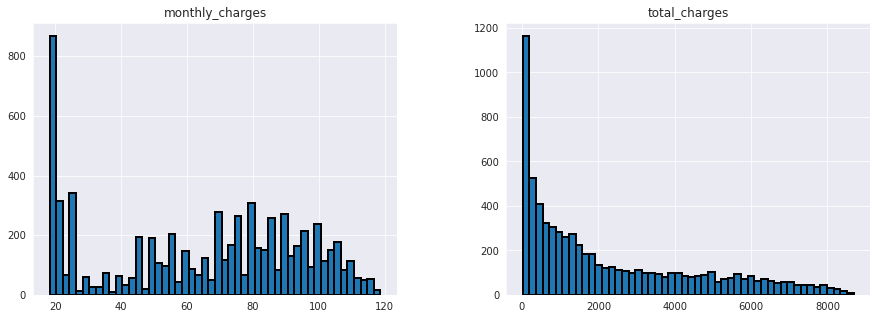

In [ ]:
df[cols].hist(bins=50, figsize=(15,5), edgecolor='black', linewidth=2)
plt.show()

Добавим новый признак `income_cat` по ежемесячной оплате. Из выборки для обучения он будет удален - для обучения моделей попробуем применять кластеризацию и подобрать корзины более точно

In [ ]:
df['income_cat'] = pd.cut(df['monthly_charges'],
                               bins=[0., 20., 40., 60., 80., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [ ]:
df['income_cat'].value_counts()

5    2666
4    1459
2    1182
3    1080
1     656
Name: income_cat, dtype: int64

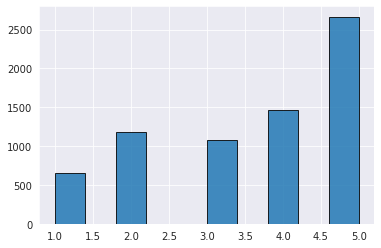

In [ ]:
df['income_cat'].hist(ec='black', alpha=.84)
plt.show()

In [ ]:
(df.groupby('income_cat')['label'].agg(['sum', 'count'])
.assign(ratio = lambda x: x['sum'] / x['count'])
).sort_values(by='ratio', ascending=False).style.background_gradient(low=0.42)

,sum,count,ratio
income_cat,,,
5,906,2666,0.339835
4,473,1459,0.324195
3,276,1080,0.255556
2,156,1182,0.131980
1,58,656,0.088415


Чем больше пользователи платят в месяц - тем выше вероятность ухода, иными словами - уходят наиболее прибыльные клиенты по неизвестной причине

In [ ]:
df[['monthly_charges', 'total_charges']].describe().T

,count,mean,std,min,25%,50%,75%,max
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
total_charges,7043.0,2279.798992,2266.730170,18.80,398.55,1394.55,3786.60,8684.80


`total_charges` сильно скошен вправо, наблюдаем длинный хвост

In [ ]:
df.groupby('label')['monthly_charges'].agg('mean')

label
0    61.265124
1    74.441332
Name: monthly_charges, dtype: float64

Проверим как отличаются средние месячные общие платежи клиентов что ушли и оставшихся   
Построим гипотезы: Сформулируем ее как Гипотезу о равенстве средних двух генеральных совокупностей

**H0 (нулевая гипотеза): Средние пользовательские платежи равны.**

**H1 (альтернативная гипотеза):Средние пользовательские платежи не равны.**



In [ ]:
df_churn = df.query('label == 1')
df_clients = df.query('label == 0')


sample_1 = df_churn['monthly_charges'][df_churn['monthly_charges'].notna()].tolist()
sample_2 = df_clients['monthly_charges'][df_clients['monthly_charges'].notna()].tolist()
alpha = .05
stat, p = stats.levene(sample_1, sample_2)
result_levene = p



if result_levene < alpha:
    print('Отвергаем Н0, дисперсии различаются')
else:
    print('Не отвергаем Н0, дисперсии не различаются')

var_sample = [np.var(x, ddof=1) for x in [sample_1, sample_2]]
print('Дисперсии по выборкам: ', var_sample)

Отвергаем Н0, дисперсии различаются
Дисперсии по выборкам:  [608.4141833954307, 966.7527670734264]


In [ ]:
alpha = .05 
results = stats.mannwhitneyu(sample_1, sample_2, alternative='two-sided')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем Н0")
else:
    print("Не отвергаем Н0")

p-значение: 3.311627651988585e-54
Отвергаем Н0


Таким образом подтверждаем, что средние месячные платежи, тех кто ушел не равны. Те кто уходит - платит больше

Посмотрим на QQ-график наших признаков и на kde

In [ ]:
def qq_plt(data):
  measurements = data
  stats.probplot(measurements, dist="norm", plot=pylab)
  plt.title('QQ-график')
  plt.xlabel('Теоретические квантили')
  plt.ylabel('Упорядоченые значения')
  pylab.show()

def kde_plot(data, col):
  plt.figure(figsize=(10,5))
  sns.kdeplot(data=data, shade=True, 
                 alpha=.5, linewidth=4.2
  )
  plt.xlabel(f"{col}")
  plt.title('KDE оценка плотности')
  plt.show()

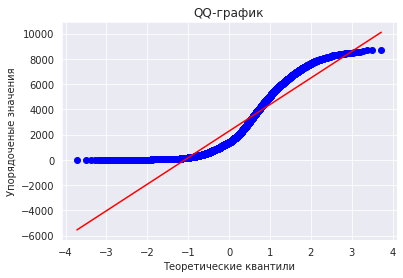

In [ ]:
qq_plt(df['total_charges'])

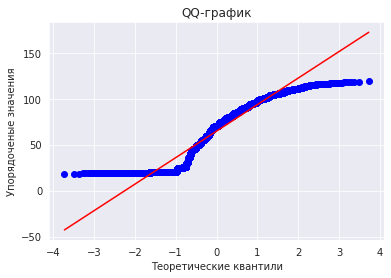

In [ ]:
qq_plt(df['monthly_charges'])

Природа наших признаков далеко от нормально распределенной

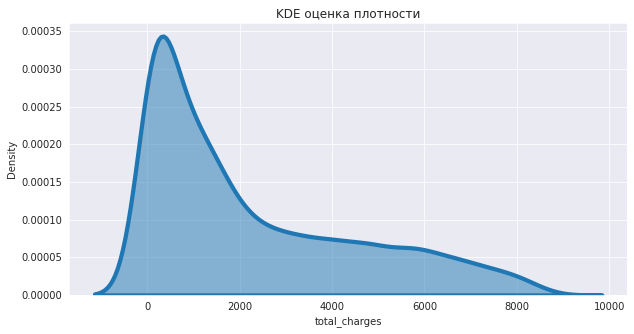

In [ ]:
kde_plot(df['total_charges'], 'total_charges')

Наблюдаем длинный хвост справа, распределение ассиметричное, скошено направо

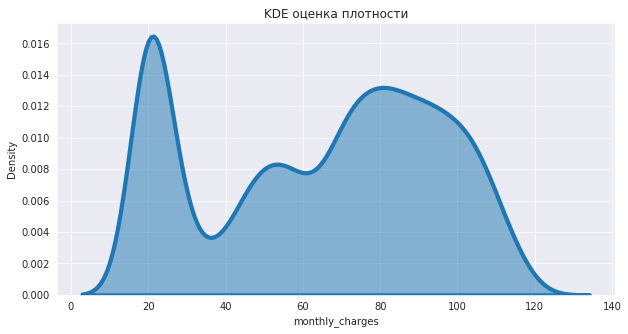

In [ ]:
kde_plot(df['monthly_charges'], 'monthly_charges')

Добавим признак по платежу - если клиент платит на год вперед - будем считать это признаком лояльности. Также внесли данный признак в pipe подгатовки сета

In [ ]:
df['loyality'] =  df['type'].apply(lambda x: 0 if x == 'Month-to-month' else 1)

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Исследование зависимости ухода от различных признаков

Посмотрим и изучим свойства пользователя, который покидает компанию

In [ ]:
def plot_hist(data, col):
  plt.figure(figsize=(12,6))
  data[col].hist(ec='black', alpha=0.84)
  data[data['label'] == 1][col].hist(ec='black', alpha=0.84)
  plt.legend(['Все пользователи', 'Отток'])
  plt.xticks(rotation=42)
  plt.title(f"Отток по признаку {col}")
  plt.ylabel('Количество человек')
  plt.show()

In [ ]:
(df.groupby('payment_method')['label'].agg(['sum', 'count'])
.assign(ratio = lambda x: x['sum'] / x['count'])
).sort_values(by='ratio', ascending=False).style.background_gradient(low=0.42)

,sum,count,ratio
payment_method,,,
Electronic check,1071,2365,0.452854
Mailed check,308,1612,0.191067
Bank transfer (automatic),258,1544,0.167098
Credit card (automatic),232,1522,0.152431


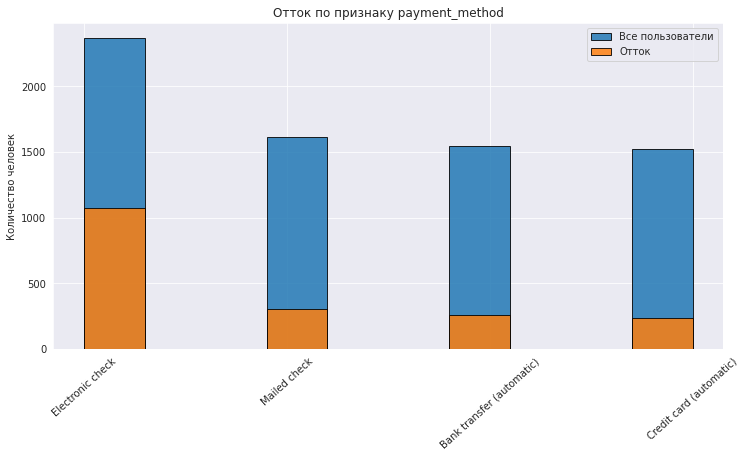

In [ ]:
plot_hist(df, 'payment_method')

Большинство пользователей выбирают электронные чеки, больше `45%` ушедших клиентов - пользовались именно данным типом получения счета и взаимодействия

In [ ]:
(df.groupby('gender')['label'].agg(['sum', 'count'])
.assign(ratio = lambda x: x['sum'] / x['count'])
).sort_values(by='ratio', ascending=False).style.background_gradient(low=0.42)

,sum,count,ratio
gender,,,
Female,939,3488,0.269209
Male,930,3555,0.261603


От пола уход не зависит, по крайней мере, явно. Выборка оказалось достаточно сбалансированной, страты соблюдены, количество мужчин и количество женщин примерно одинаковы - это хорошо для нас.

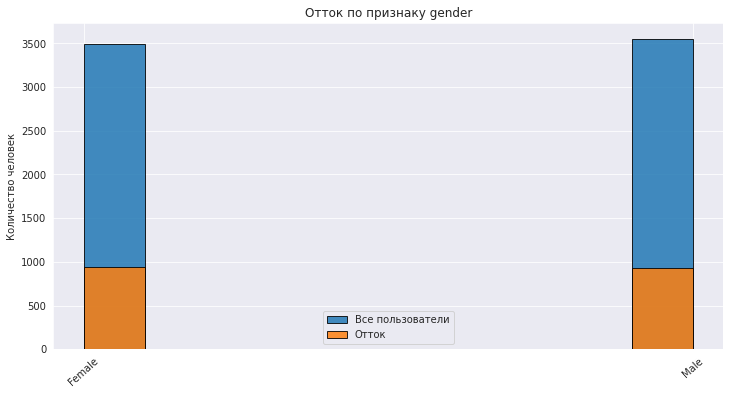

In [ ]:
plot_hist(df, 'gender')

In [ ]:
(df.groupby('type')['label'].agg(['sum', 'count'])
.assign(ratio = lambda x: x['sum'] / x['count'])
).sort_values(by='ratio', ascending=False).style.background_gradient(low=0.42)

,sum,count,ratio
type,,,
Month-to-month,1655,3875,0.427097
One year,166,1473,0.112695
Two year,48,1695,0.028319


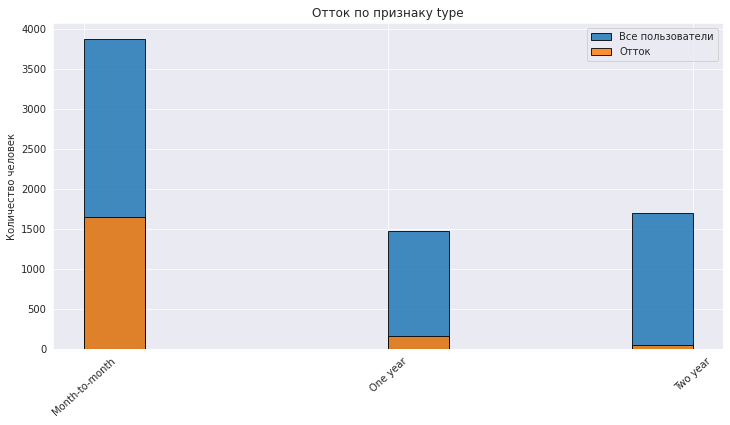

In [ ]:
plot_hist(df, 'type')

Пользователи, пользующиейся месячной подпиской - чаще уходят, нежеле те, кто предпочитает долгосрочные контракты

In [ ]:
(df.groupby('internet_service')['label'].agg(['sum', 'count'])
.assign(ratio = lambda x: x['sum'] / x['count'])
).sort_values(by='ratio', ascending=False).style.background_gradient(low=0.42)

,sum,count,ratio
internet_service,,,
Fiber optic,1297,3096,0.418928
DSL,459,2421,0.189591
No,113,1526,0.074050


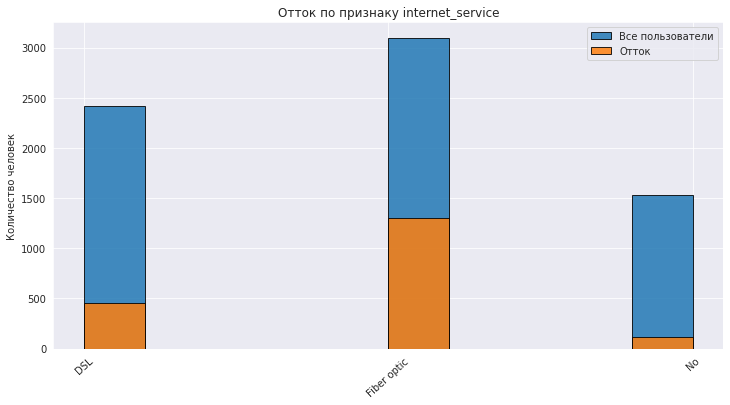

In [ ]:
plot_hist(df, 'internet_service')

Пользователи, которые пользуются оптоволокном чаще уходят

По остальным признакам пройдем с помощью только гистограмм

In [ ]:
def plot_hist_groups(data, cols, n_cols):

  fig, ax = plt.subplots(nrows=1, ncols=n_cols, figsize = (15,4))
  for i, col in enumerate(cols):

      ax[i].hist(data[col], ec='black', alpha=0.84)
      ax[i].hist(data[data['label'] == 1][col], ec='black', alpha=0.84)
      ax[i].set_title(f"Отток по признаку {col}")
      ax[i].legend(['Все пользователи', 'Отток'])

  plt.ylabel('Количество человек')
  fig.autofmt_xdate()
  plt.tight_layout()
  plt.show()

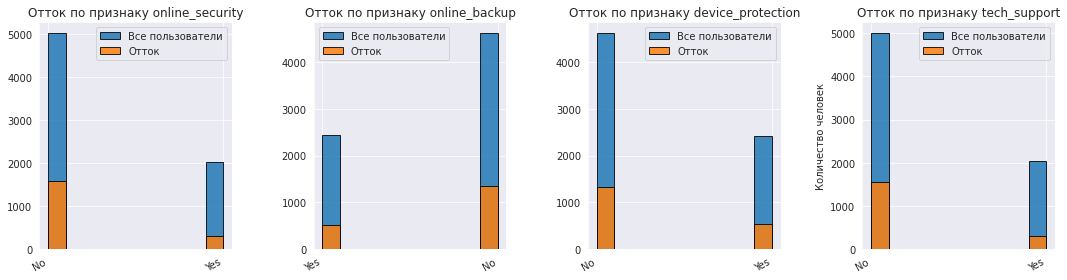

In [ ]:
cols = ['online_security', 'online_backup', 'device_protection', 'tech_support']
plot_hist_groups(df, cols, 4)

Чаще всего уходят пользователи, не пользующиеся услугами: `online_security`, `online_backup`, `tech_support` и `device_protection`

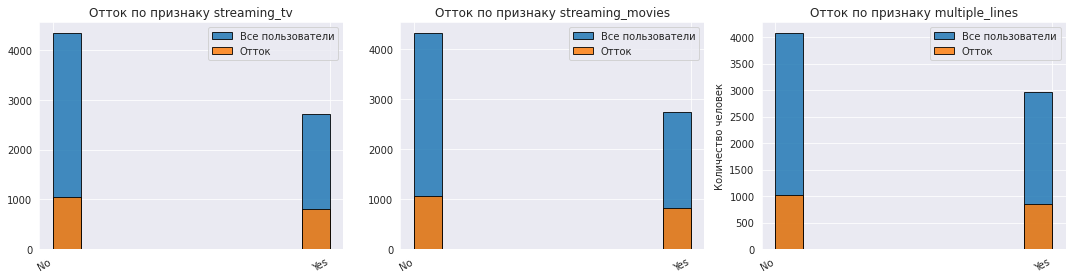

In [ ]:
cols = ['streaming_tv', 'streaming_movies', 'multiple_lines']
plot_hist_groups(df, cols, 3)


Со стриминговыми услугами не все так однозначно. Пользователи пользующиеся услугами и нет уходят практически равнозначно. Аналогично по тем пользователям, что используют несколько линий

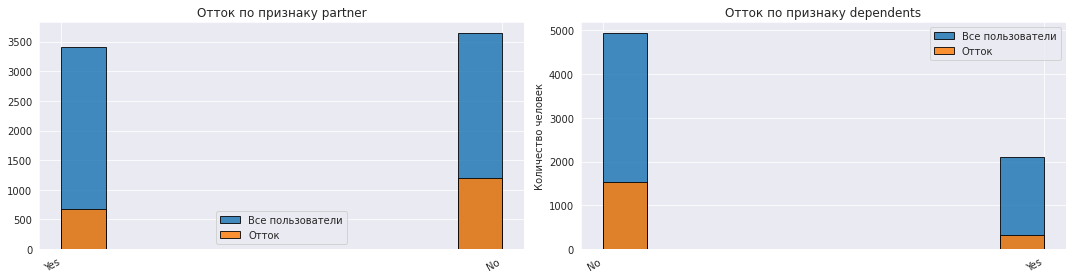

In [ ]:
cols = ['partner', 'dependents']
plot_hist_groups(df, cols, 2)

Те пользователи, что не состоят в браке уходят чаще, нежеле те, находится в узаконеных отношениях. Также стоит отметить, что пользователи, которые являются иждевенцами - реже покидают компанию - они не выбирают, выбирают за них

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Проверка на мультиколлинеарность и взаимную информацию

На заключительном этапе подготовки данных проверим мультиколлинеарность между нашими численными данными. Если значение будет превышать 0.8 - сильная корреляция - избавимся от лишних признаков, чтобы улучшить обобщение. Воспользуемся Корреляцией Пирсона и [Phik-корреляцией](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7) - достаточно новой, но способной, как заявлено - анходить зависимости в нелинейных связях. Также проверим взаимную информацию категориальных признаков.  Подготовим наши данные:

In [ ]:
df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,end_date_02_20,total_days,label,income_cat,loyality
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No,2020-02-01,31,0,2,0
1,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,2020-02-01,1036,0,3,1
2,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,2019-12-01,61,1,3,0
3,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,No,2020-02-01,1371,0,3,1
4,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,2019-11-01,61,1,4,0


In [ ]:
corr_check = df[['monthly_charges', 'total_charges', 'total_days']].copy()

In [ ]:
plot_values = df[['monthly_charges', 'total_charges', 'total_days', 'label']].copy()

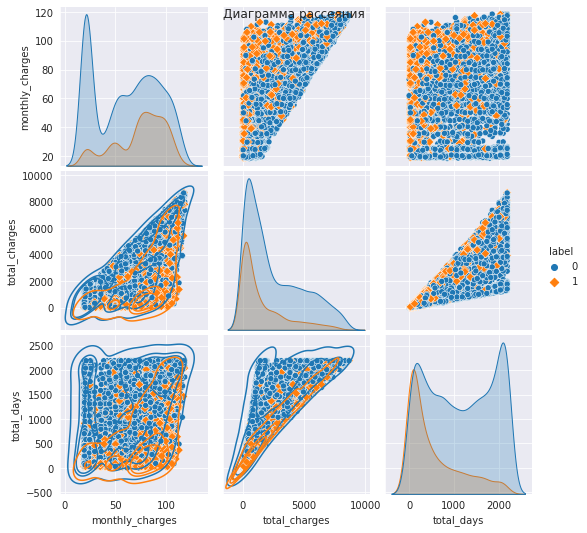

In [ ]:
map_corr = sns.pairplot(plot_values, hue='label', markers=["o", "D"])
(map_corr.map_lower(sns.kdeplot, levels=4, color=".1")
.fig.suptitle('Диаграмма рассеяния'))
plt.show()

На диаграмме прослеживается зависимость между признаками `total_charges` и `month_charges` и сильная между `total_charges` и `total_days`. Посмотрим коэффциенты корреляции

#### Корреляция Пирсона

In [ ]:
corr_check.corr(method='pearson')

,monthly_charges,total_charges,total_days
monthly_charges,1.000000,0.651182,0.247754
total_charges,0.651182,1.000000,0.826095
total_days,0.247754,0.826095,1.000000


#### Корреляция Phik

In [ ]:
phik_overview = corr_check.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'total_days']


,monthly_charges,total_charges,total_days
monthly_charges,1.00,0.76,0.41
total_charges,0.76,1.00,0.84
total_days,0.41,0.84,1.00


Сильная корреляция наблюдается по двум признакам - `total_days` и `total_charges` - удалим `total_charges` - его мы получим из дней и ежемесячной оплаты	

#### Взаимная информация

Теперь обратимся к взаимной информации. Для этого переведем наши категориальные признаки к челочисленным с помощью кодирования:

In [ ]:
X = prep_df.copy()
y = X.pop('label')

for col in list(X.select_dtypes(['object', 'category']).columns):
    X[col], _ = X[col].factorize()

discrete_features = X.dtypes == int

Данные преобразовали - можем посмотреть взаимную информацию:

In [ ]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name='mutual_information оценка', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3].to_frame('Mi_scores')

,Mi_scores
total_days,0.334332
payment_method,0.044519
internet_service,0.031370
tech_support,0.014608
senior_citizen,0.010577
streaming_tv,0.001981
gender,0.000037


Больше всего информации о целевом признаке содержится в `total_days` и `payment_method`. Но не так значительно, чтобы удалять из обучения total_days

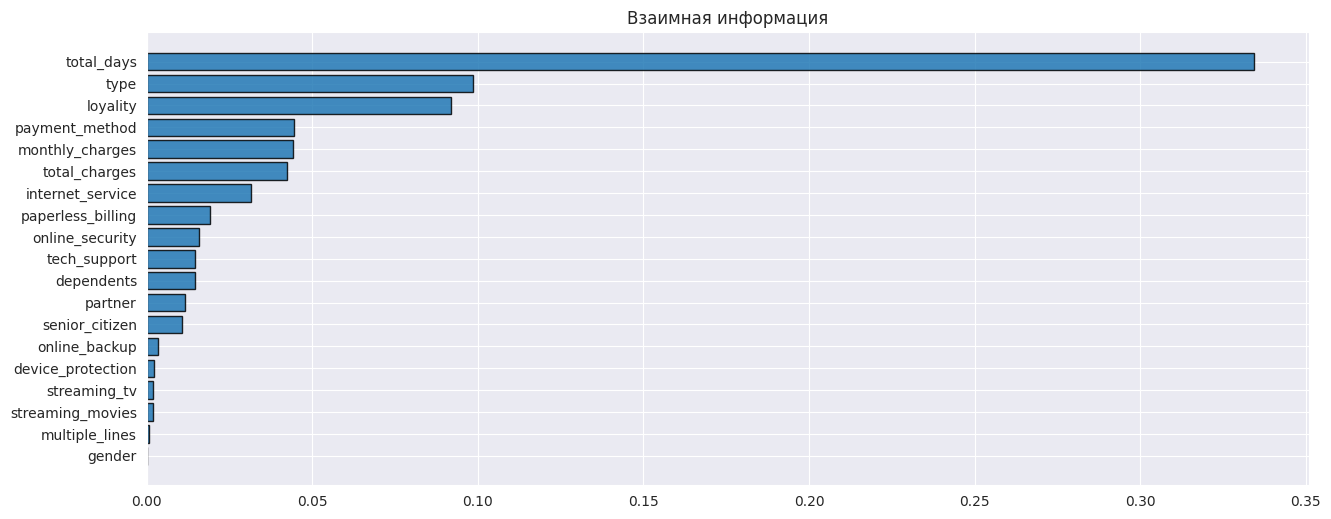

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores, ec='black', alpha=0.84)
    plt.yticks(width, ticks)
    plt.title('Взаимная информация')


plt.figure(dpi=100, figsize=(15, 6))
plot_mi_scores(mi_scores)

Фактически - признак `total_days` будет определять таргет в большей мере. Без данного признака удалось достичь оценки ROC-AUC 0.87. Обучать будем с данным признаком - он рассчетный, признак `total_charges` будет удален из обучения. Во время обучения будем смотреть также `features importance` моделей и сравним с результами исследования


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

**Выводы**


Компанию покидают чаще всего те пользователи, что используют:

 - электронные чеки
 - используют помесячную оплату - здесь можно предложить скидки за оплату на более долгий срок
 - не используют дополнительные услуги в виде антивируса, облачного хранилища, выделенной линии с технической поддержкой и защиты оборудования - возможно данные услуги стоит включать в предложения для пользователей в качестве рекомендации (Интернет-безопасность: антивирус (***DeviceProtection***) и блокировка небезопасных сайтов (***OnlineSecurity***); выделенная линия технической поддержки (***TechSupport***); Облачное хранилище файлов для резервного копирования данных (***OnlineBackup***)
 - не состоят в браке
 - чем выше помесячная оплата - тем выше вероятность ухода. Возможно, стоит рассмотреть необходимость стимуляции для перехода на более выгодные тарифы

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

## План решения задачи

Данные для обучению предлагаю использовать, подготовленные с помощью [pipe](#Pipe) методов 

In [ ]:
prep_df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,label,loyality,total_days
0,Month-to-month,Yes,Electronic check,29.85,29.85,1,No,Yes,No,No,No,No,Female,0,Yes,No,No,0,0,31
1,One year,No,Mailed check,56.95,1889.50,1,Yes,No,Yes,No,No,No,Male,0,No,No,No,0,1,1036
2,Month-to-month,Yes,Mailed check,53.85,108.15,1,Yes,Yes,No,No,No,No,Male,0,No,No,No,1,0,61
3,One year,No,Bank transfer (automatic),42.30,1840.75,1,Yes,No,Yes,Yes,No,No,Male,0,No,No,No,0,1,1371
4,Month-to-month,Yes,Electronic check,70.70,151.65,1,No,No,No,No,No,No,Female,0,No,No,No,1,0,61


In [ ]:
print('Признаки для обучения модели и целевой label')
print('___________________________')
for col in list(prep_df.columns):
  print(col)

Признаки для обучения модели и целевой label
___________________________
type
paperless_billing
payment_method
monthly_charges
total_charges
internet_service
online_security
online_backup
device_protection
tech_support
streaming_tv
streaming_movies
gender
senior_citizen
partner
dependents
multiple_lines
label
loyality
total_days


In [ ]:
prep_df['label'].value_counts(normalize=True).to_frame('Соотношение классов')

,Соотношение классов
0,0.73463
1,0.26537


1. На первом этапе подготовили и проработали `pipeline` по подготовке признаков. В будущем можно автоматизировать загрузку с применением `chaining` методов, предлагаемых `Pandas`

2. У нас наблюдается дисбаланс классов. Уточнений о важности того или иного класса не поступит - будем предсказывать со стандартным порогом `0.5`, при этом использовать метод стратифицированного отбора и метод предсказания на кросс-валидации. Использовать планирую бустинговую модель `XGboost`, `Catboost`, `LightGBM`, стэккинг на базе моделей из семейства опорных векторов, случайного леса и Логистической регресии `SKlearn` с мета учеником на базе `Keras` модели, неглубокой. Параметры подбирать планирую `Optuna`

3. Планируем применять StandardScaler для количественных признаков, для того чтобы придать им одинаковый масштаб и нормальную форму

4. Для категориальных признаков планирую применять `OrdinalEncoder` (Порядковый). Планировалось применять `OneHotEncoder` для бинарных (`Yes-No`) - но было принято решение заполнить пропуски значением `No`

5. Данные преобразования будут выполняться через `Pipeline`ю Произведем замеры по времени обучения и предсказания. Сравним различные модели и сделаем выводы

## Подготовка данных для обучения

Разделим выборку на обучающую и выборку для тестирования

In [ ]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]

In [ ]:
features, target = split_data(prep_df, 'label')
features.shape, target.shape

((7043, 19), (7043,))

In [ ]:
X_train , X_test , y_train , y_test, = train_test_split ( 
                                features, target, test_size=0.25, random_state=42)


In [ ]:
X_train.shape[0] + X_test.shape[0]

7043

In [ ]:
y_train.shape, y_test.shape

((5282,), (1761,))

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

#### Кластеризация и подбор оптимального количества кластеров для `monthly_charges` и `total_charges`

Добавим дополнительный признак - кластер для помесячной оплаты клиента

In [ ]:
optimal_clusters = X_train[['monthly_charges', 'total_charges']]

Оптимальное число кластеров будем подбирать по методу локтя

In [ ]:
distortion = []
K = range(1, 8)
for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(optimal_clusters)
    distortion.append(model.inertia_) 

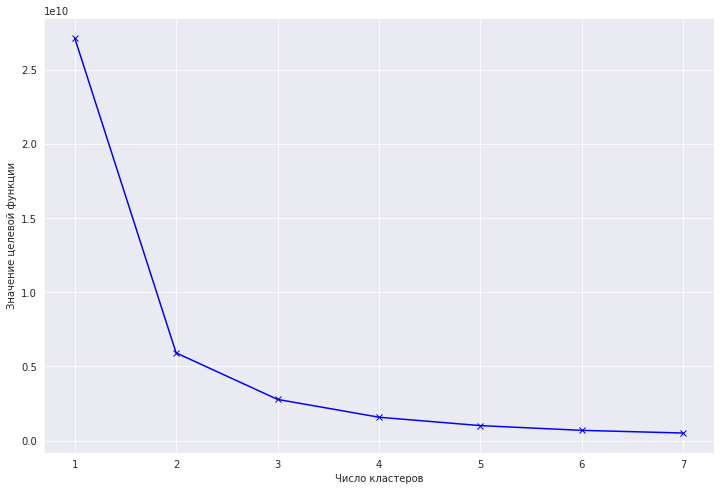

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show() 

Посмотрим наши целевые группы:

In [ ]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(optimal_clusters)
print("Типичные пользователи сегментов для 3-х кластеров:")
print(np.round(model.cluster_centers_))

Типичные пользователи сегментов для 3-х кластеров:
[[  50.  685.]
 [  78. 3273.]
 [  98. 6286.]]


**Средний класс: `78 руб.` в месяц и `3273 руб.` всего**   
**Продвинутый класс: `98 руб.` в месяц и `6386 руб.` всего**    
**Базовый класс: `50 руб.` в месяц и `685 руб.` всего**    

Центроиды признаков выручки


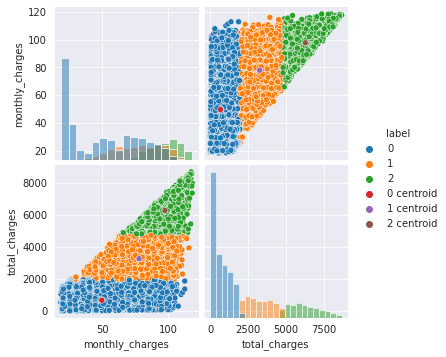

In [ ]:
print('Центроиды признаков выручки')
centroids = pd.DataFrame(model.cluster_centers_, columns=optimal_clusters.columns)
optimal_clusters['label'] = model.labels_.astype(str)
centroids['label'] = ['0 centroid', '1 centroid', '2 centroid']
data_cluster = pd.concat([optimal_clusters, centroids], ignore_index=True)
sns.pairplot(data_cluster, hue='label', diag_kind='hist')
plt.show()


Остановимся на трех кластерах

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

## Pipeline предобработки

`Pipeline` будет состоять из следующих компонентов:

1. `StandardScaler` для числовых признаков
2. `OrdinalEncoder` для порядковых признаков
3. `OneHotEncoder` для бинарных признаков
4. `Kmean` для создания дополнительного признака в виде кластера
5. `delete_cols_array` для удаления признаков вспомогательных из `np.ndarray`

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 6607 to 860
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               5282 non-null   object  
 1   paperless_billing  5282 non-null   object  
 2   payment_method     5282 non-null   object  
 3   monthly_charges    5282 non-null   float64 
 4   total_charges      5282 non-null   float64 
 5   internet_service   5282 non-null   category
 6   online_security    5282 non-null   object  
 7   online_backup      5282 non-null   object  
 8   device_protection  5282 non-null   object  
 9   tech_support       5282 non-null   object  
 10  streaming_tv       5282 non-null   object  
 11  streaming_movies   5282 non-null   object  
 12  gender             5282 non-null   object  
 13  senior_citizen     5282 non-null   category
 14  partner            5282 non-null   object  
 15  dependents         5282 non-null   object  
 16  mult

In [ ]:
X_train.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,loyality,total_days
6607,Month-to-month,Yes,Electronic check,25.30,25.30,1,No,No,No,No,No,No,Male,0,No,Yes,No,0,31
2598,Month-to-month,Yes,Electronic check,75.15,525.00,1,No,No,Yes,No,No,No,Female,0,No,No,No,0,215
2345,Month-to-month,Yes,Bank transfer (automatic),20.05,85.50,0,No,No,No,No,No,No,Female,0,No,Yes,No,0,123
4093,Month-to-month,Yes,Credit card (automatic),76.00,2215.25,1,No,No,No,No,No,No,Female,0,No,No,Yes,0,883
693,Month-to-month,Yes,Credit card (automatic),75.10,270.70,1,No,No,No,No,No,No,Female,0,No,No,Yes,0,92


Составим списки признаков для обработки в `Pipeline`

In [ ]:
cluster_cols = ['monthly_charges', 'total_charges']
num_features = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
cat_features = ['payment_method', 'type']
binary_features = list(set(list(X_train.select_dtypes(exclude=['int64', 'float64']).columns)) - set(cat_features) - set(['internet_service']))

Создадим вспомогательный класс для `KMeans` и функцию для удаления лишних признаков - с целью демонстрации работы `Pipeline`

In [ ]:
class AttributAdder(BaseEstimator, TransformerMixin):
    """класс для добавления Кластеров. Удаление столбцов в Pipeline через
    FunctionTransformer """
    
    def __init__(self, attr = True):
        self.attr = attr

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        kmeans = KMeans(n_clusters=3, random_state=42)
        X['cluster'] = kmeans.fit_predict(X)
        X['cluster'] = X['cluster'].astype("category")
        
        return X

In [ ]:
def delete_cols_array(X):
    arr = np.array([1, 18, 19])
    X = np.delete(X, arr, 1)
    return X



def return_DF(X):
    cols = (['monthly_charges', 'total_days'] + 
            cat_features +  
            binary_features +
            ['cluster'])

    X = pd.DataFrame(X, columns=cols)
    cols_type = (cat_features +  
            binary_features +
            ['cluster'])
    for col in cols:
      X[col] = X[col].astype('float64')
    return X    

Создадим `Pipeline`

In [ ]:
preprocessor = ColumnTransformer (
    transformers = [
        
        ('std_scaler' , StandardScaler() , num_features) ,
        ('cat' , OrdinalEncoder() , cat_features) ,
        ('binary' , OneHotEncoder(drop='first') , binary_features),
        ('kmeans', AttributAdder(), cluster_cols),
        
        ]
)

pipe = Pipeline(steps=
    
    [
     ('preprocessor', preprocessor),
     ('delete_cols_array', FunctionTransformer(delete_cols_array, validate=False)),
     ('return_DF', FunctionTransformer(return_DF, validate=False))

     ]
)


In [ ]:
X_train.shape

(5282, 19)

In [ ]:
X_train_prep = pipe.fit_transform(X_train)

Проверим работоспособность `Pipeline`

In [ ]:
X_train_prep.shape

(5282, 18)

In [ ]:
X_train_prep.head()

,monthly_charges,total_days,payment_method,type,multiple_lines,streaming_movies,tech_support,partner,loyality,online_backup,paperless_billing,senior_citizen,dependents,online_security,gender,streaming_tv,device_protection,cluster
0,-1.310046,-1.282970,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.344832,-1.036117,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.484331,-1.159543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.373049,-0.139933,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.343172,-1.201133,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Получили ожидаемый результат - на выходе преобразованный `DataFrame Pandas` - это позволит использовать `iloc`, который понадобится нам при обучении моделей. Можем приступать к подготовке моделей. Создадим вспомогательные таблицы для подготовки отчета

In [ ]:
auc = []
accuracy = []
training_time = []
prediction_time = []
model_name = []

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### XGboost базовый c преобразованиями

Так как у нас наблюдается дисбалас классов - необходимо это учесть в обучении. Будем взвешивать целевые переменные при обучении. Также попробуем различные ансамблевые методы - кросс-валидация, стэккинг, голосование и upsampling

In [ ]:
y_train.value_counts(normalize=True).to_frame('Доля классов')

,Доля классов
0,0.736842
1,0.263158


Подготовим тестовую выборку с помощью `Pipline`, затем выделим валидационную выборку для нашей модели

In [ ]:
X_test_prep = pipe.transform(X_test)

In [ ]:
X_train_prep.shape, X_test_prep.shape, y_train.shape, y_test.shape

((5282, 18), (1761, 18), (5282,), (1761,))

In [ ]:
X, X_val, y, y_val = train_test_split(X_train_prep, y_train, test_size=0.2,
                                      random_state=42)

Обучим модель

In [ ]:
%%time
start = time.time()

classes_weights = class_weight.compute_sample_weight(
                  class_weight='balanced',
                  y = y_train)
model = XGBClassifier(sample_weight=classes_weights,
                                    random_state=42,
                                    eval_metric ='logloss')
model.fit(X, y, eval_set = [(X_val, y_val)],
              early_stopping_rounds=200, verbose=50)

end = time.time()
elapsed = end - start

[0]	validation_0-logloss:0.653497
Will train until validation_0-logloss hasn't improved in 200 rounds.
[50]	validation_0-logloss:0.386287
[99]	validation_0-logloss:0.373813
CPU times: user 405 ms, sys: 24 ms, total: 429 ms
Wall time: 551 ms


In [ ]:
start_pred = time.time()
y_pred = model.predict_proba(X_test_prep)[:, 1]
end_pred = time.time()
elapsed_pred = end_pred - start_pred

y_bin = (y_pred >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
auc.append(roc_auc_score(y_test, y_pred))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str(model.__class__.__name__)+str(' ')+str('базовый')))

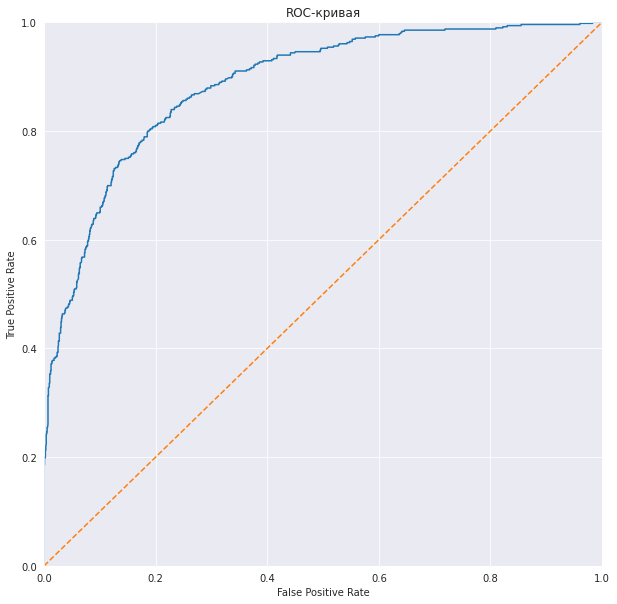

AUC: 0.8858198795592742


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print("AUC:", roc_auc_score(y_test, y_pred))

Получили достаточно высокий результат - удовлетворяющий требуемому качеству. Попробуем его улучшить с помощью предсказаний на `StratifiedFolds` и через тюнинг параметров  

Но сначала попробуем посмотреть на `PR` кривую

[0]	validation_0-logloss:0.653497
Will train until validation_0-logloss hasn't improved in 200 rounds.
[50]	validation_0-logloss:0.386287
[99]	validation_0-logloss:0.373813
Порог = 0.00 | Точность = 0.272, Полнота = 1.000 | F1-мера = 0.428
Порог = 0.05 | Точность = 0.363, Полнота = 0.983 | F1-мера = 0.530
Порог = 0.10 | Точность = 0.409, Полнота = 0.954 | F1-мера = 0.573
Порог = 0.15 | Точность = 0.456, Полнота = 0.937 | F1-мера = 0.613
Порог = 0.20 | Точность = 0.496, Полнота = 0.910 | F1-мера = 0.642
Порог = 0.25 | Точность = 0.548, Полнота = 0.866 | F1-мера = 0.672
Порог = 0.30 | Точность = 0.595, Полнота = 0.814 | F1-мера = 0.688
Порог = 0.35 | Точность = 0.646, Полнота = 0.754 | F1-мера = 0.696
Порог = 0.40 | Точность = 0.695, Полнота = 0.699 | F1-мера = 0.697
Порог = 0.45 | Точность = 0.736, Полнота = 0.622 | F1-мера = 0.674
Порог = 0.50 | Точность = 0.763, Полнота = 0.530 | F1-мера = 0.626
Порог = 0.55 | Точность = 0.838, Полнота = 0.463 | F1-мера = 0.597
Порог = 0.60 | Точность

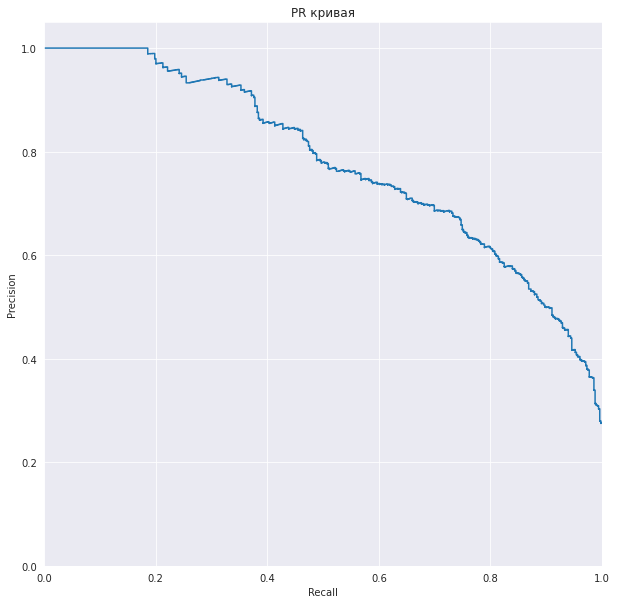

In [ ]:
classes_weights = class_weight.compute_sample_weight(
                  class_weight='balanced',
                  y = y_train)
model = XGBClassifier(sample_weight=classes_weights,
                                    random_state=42,
                                    eval_metric ='logloss')
model.fit(X, y, eval_set = [(X_val, y_val)],
              early_stopping_rounds=200, verbose=50)
probabilities_valid = model.predict_proba(X_test_prep)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(y_test, predicted_valid)
    recall = recall_score(y_test, predicted_valid)
    f1 = f1_score(y_test, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f} | F1-мера = {:.3f}".format(
        threshold, precision, recall, f1))

precision, recall, thresholds = precision_recall_curve(y_test, probabilities_valid[:, 1])    
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR кривая')
plt.show() 

Для порога 0 полнота равна 1 - все ответы положительные. При пороге `0.85` модель перестает давать правильные ответы. Самый высокий показатель `F1` наблюдаем с порогом `0.35-0.40`. В дальнейшем будем смотреть на `ROC-AUC` кривую и `AUC` - уточнений о важности классов не поступало. Посмотрим на важность признаков.


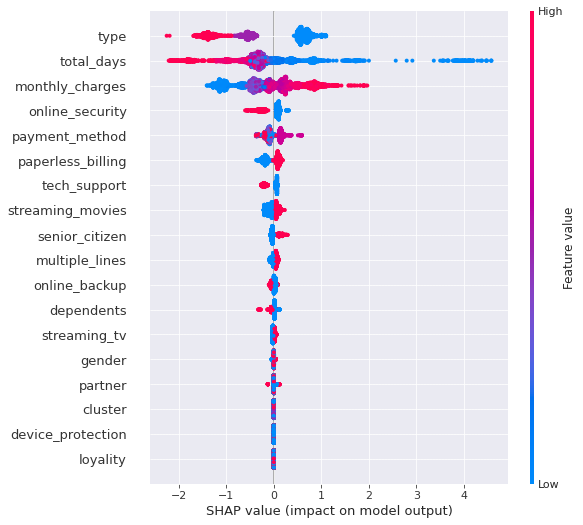

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

Данные подтверждают наши выводы в `EDA`:   


Компанию покидают чаще всего те пользователи, что используют:
краткосрочные договора  
электронные чеки  
используют помесячную оплату
не используют дополнительные услуги в виде антивируса, облачного хранилища, выделенной линии с технической поддержкой и защиты оборудования


#### Калибровка классификации

Откалибруем наши предсказания, что получить уверенность в нашем прогнозе - изучим наши предсказания и построим диаграмму надежности

In [ ]:
prob_true, prob_pred = calibration_curve(y_test, 
                                         y_pred,
                                         normalize=False,
                                         n_bins=3,
                                         strategy='uniform')
print(prob_true[:5])
print(prob_pred[:5])

[0.09215017 0.50827423 0.93975904]
[0.11422485 0.47599428 0.84342377]


Как видим, вероятности классов немного отличаются. Построим кривую калибровки:

In [ ]:
def plot_calibration_curve(y_true, y_pred, normalize=False, n_bins=3):
  prob_true, prob_pred = calibration_curve(y_true, 
                                         y_pred,
                                         normalize=normalize,
                                         n_bins=n_bins,
                                         strategy='uniform')
  ax = plt.gca()
  ax.plot([0, 1], [0, 1], ':', c='k')
  curve = ax.plot(prob_true, prob_pred, marker='o')
  ax.set_xlabel('Спрогнозированная вероятность в бине')
  ax.set_ylabel('Доля наблюдений положительного класса в бине')
  ax.set(aspect='equal')
  return curve

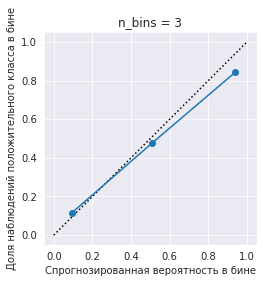

In [ ]:
plot_calibration_curve(y_test, y_pred, n_bins=3)
plt.title('n_bins = 3')
plt.tight_layout()

По оси $x$ откладывается вероятность спрогнозированного класса, по оси $y$ - доля наблюдений фактического класса в бине - чем они ближе - тем лучше - то есть если классификатор уверен на $80\%$, то он должен быть прав на $80\%$ . Если точка лежит под диагональю - у нас недопрогноз, если выше - перепрогноз

Попробуем откалибровать нашу модель - для этого необходимо выставить параметр `cv='prefit'` если мы не хотим обучать ее вновь, либо оставляем `cv=None` - тогда будет применяться `StratifiedKFold` 

In [ ]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
model = pickle.load(open('/content/finalized_model.sav', 'rb'))

In [ ]:
cols_when_model_builds = model.get_booster().feature_names

In [ ]:
X_val = X_val[cols_when_model_builds]

In [ ]:
model_calibrated = CalibratedClassifierCV(model, cv=5, method='sigmoid')
model_calibrated.fit(X_train_prep, y_train)
preds = model_calibrated.predict_proba(X_test_prep)[:, 1]

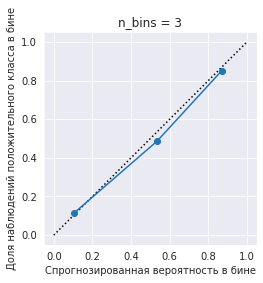

In [ ]:
plot_calibration_curve(y_test, preds, n_bins=3)
plt.title('n_bins = 3')
plt.tight_layout()

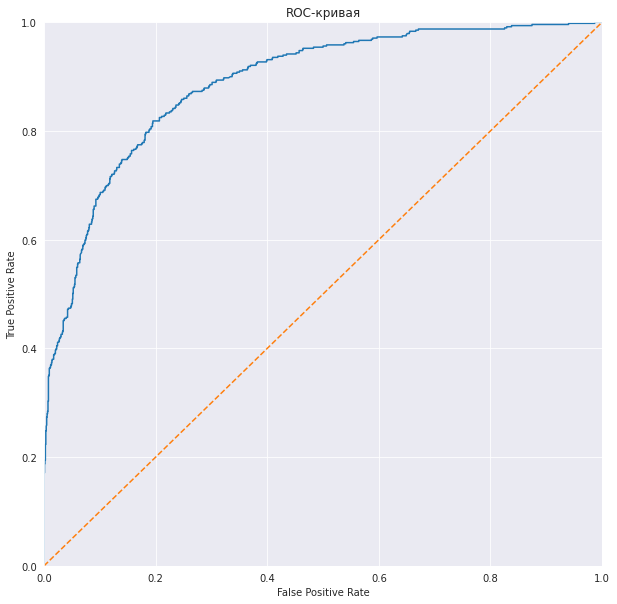

AUC: 0.8874678786733933


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, preds)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print("AUC:", roc_auc_score(y_test, preds))

Как видим - общий скор немного улучшился и при этом вероятности классов становятся более точными

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### LightGBM с GridSearch

Попробуем `LGBM` через `GridSearchCV` из `sklearn` - подберем лучшие параметры и посмотрим на результаты

In [ ]:
%%capture
train_X = features.copy()
train_X.drop('total_charges', axis=1, inplace=True)

In [ ]:
X_train , X_test , y_train , y_test, = train_test_split ( 
                                train_X, target, test_size=0.25, random_state=42)

In [ ]:
cat_features_light = list(X_train.select_dtypes(include=['object', 'category']))

In [ ]:
len(cat_features_light)

16

`LGBM` работает лучше и быстрее без `Ohe` и `Ordinal` кодирования. Поэтому преобразуем наши выборки для `LGBM` - переведем все в `category` кроме числовых

In [ ]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()
X_train_lgbm[cat_features_light] = (X_train[cat_features_light]
                                    .apply(lambda x: x.astype('category')))
X_test_lgbm[cat_features_light] = (X_test[cat_features_light]
                                   .apply(lambda x: x.astype('category')))

In [ ]:
X_train_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 6607 to 860
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               5282 non-null   category
 1   paperless_billing  5282 non-null   category
 2   payment_method     5282 non-null   category
 3   monthly_charges    5282 non-null   float64 
 4   internet_service   5282 non-null   category
 5   online_security    5282 non-null   category
 6   online_backup      5282 non-null   category
 7   device_protection  5282 non-null   category
 8   tech_support       5282 non-null   category
 9   streaming_tv       5282 non-null   category
 10  streaming_movies   5282 non-null   category
 11  gender             5282 non-null   category
 12  senior_citizen     5282 non-null   category
 13  partner            5282 non-null   category
 14  dependents         5282 non-null   category
 15  multiple_lines     5282 non-null   category
 16  loya

In [ ]:
model = LGBMClassifier(random_state=42, class_weight = 'balanced')

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
params_space = {'n_estimators': [500, 1000],
                  'learning_rate': [0.01, 0.4],
                  'max_depth': [10, 25],
                  'num_leaves':[31, 40, 60]}

grid_cv = GridSearchCV(model, params_space, scoring='roc_auc', cv=cv)
grid_cv.fit(X_train_lgbm, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
             error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt',
                                      class_weight='balanced',
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves...ive=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='

In [ ]:
grid_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 25,
 'n_estimators': 1000,
 'num_leaves': 60}

In [ ]:
estimator = grid_cv.best_estimator_

In [ ]:
start_pred = time.time()
y_pred = estimator.predict_proba(X_test_lgbm)[:, 1]
end_pred = time.time()
elapsed_pred = end_pred - start_pred

y_bin = (y_pred >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
auc.append(roc_auc_score(y_test, y_pred))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str('LightGBM')+str(' ')+str('GridSearCVcategory')))

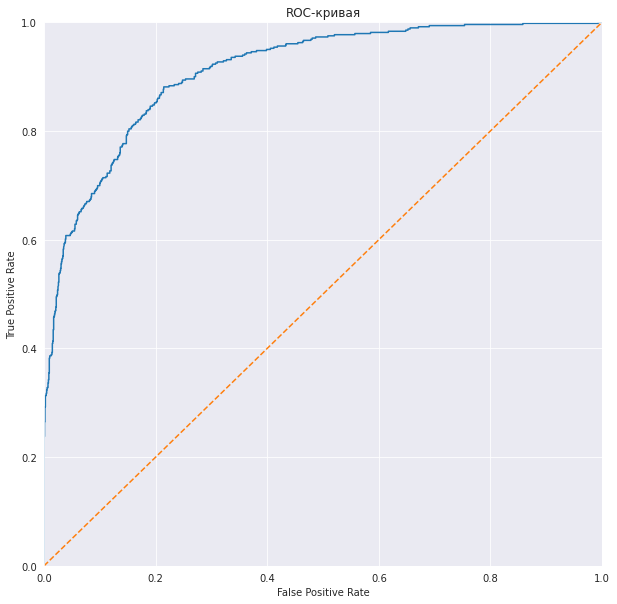

AUC: 0.91037376359355


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print("AUC:", roc_auc_score(y_test, y_pred))

Результат достаточно высокий. посмотрим другие модели и в конце сделаем заключение

In [ ]:
fi = (pd.DataFrame({'feature': list(X_train.columns), 
                    'importance': estimator.feature_importances_})
.sort_values(by='importance', ascending=False))

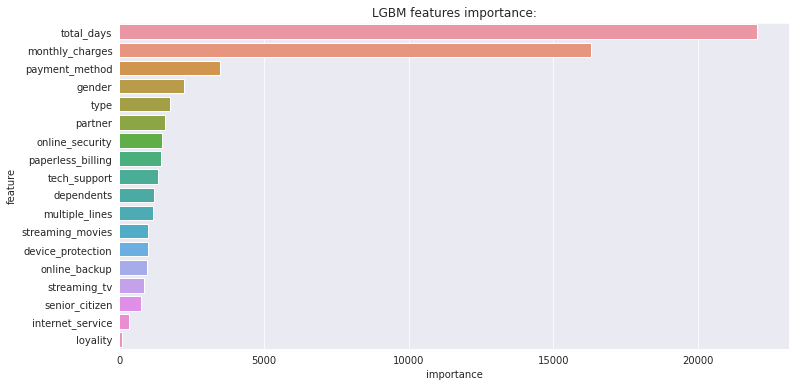

In [ ]:
plt.figure(figsize=(12, 6));
sns.barplot(x="importance", y="feature", data=fi);
plt.title('LGBM features importance:');

Признаки по важности мало отличаются от тех, что использовал `XGboost`

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### XGboost базовый c преобразованиями с `cross_validate`, `cross_val_predict`

Попробуем проверить работоспособность модели через `cross_validate` и `cross_val_predict` - данный способ поможет определить возможность использования модели в ансамбле

In [ ]:
%%time
start = time.time()

classes_weights = class_weight.compute_sample_weight(
                  class_weight='balanced',
                  y = y_train)

est = XGBClassifier(sample_weight=classes_weights,
                                    random_state=42,
                                    eval_metric ='logloss')

score = cross_validate(est, X_train_prep, y_train,
                           scoring=['roc_auc', 'accuracy'],
                           n_jobs=-1, verbose=0)
end = time.time()
elapsed = end - start
sorted(score.keys())

CPU times: user 55.8 ms, sys: 3.71 ms, total: 59.5 ms
Wall time: 1.31 s


In [ ]:
score['test_accuracy']

array([0.85335856, 0.82497635, 0.83143939, 0.82102273, 0.81344697])

In [ ]:
score['test_roc_auc']

array([0.88938272, 0.86151541, 0.85826506, 0.86197315, 0.86416009])

In [ ]:
start_pred = time.time()
y_pred = cross_val_predict(est, X_train_prep, y_train, n_jobs=-1, 
                           verbose=0, method='predict_proba')[:, 1]
end_pred = time.time()
elapsed_pred = end_pred - start_pred

In [ ]:
y_bin = (y_pred >= 0.5)*1
accuracy.append(accuracy_score(y_train, y_bin))
auc.append(roc_auc_score(y_train, y_pred))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str('XGBClassifier')+str(' ')+str('sklearn CV')))

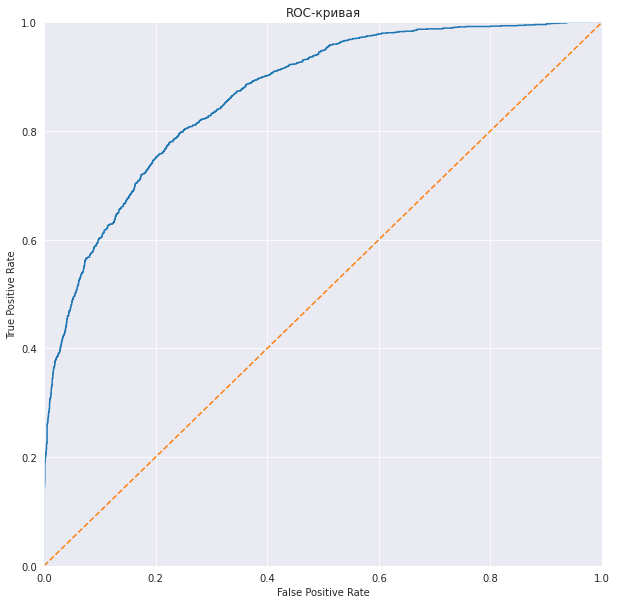

AUC: 0.8662901949765984


In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print("AUC:", roc_auc_score(y_train, y_pred))

В дальнейшем будем использовать ручной метод предсказаний на `Fold с CV`. 

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### XGboost базовый c преобразованиями с кроссвалидацией

Попробуем ту же модель, но предсказания делать будем с помощью `StratifiedKFold` - получится ансамбль моделей

In [ ]:
%%time

prediction = np.zeros(X_test_prep.shape[0])
n_fold = 5 
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42) 
rocauc_report = []
idx=0

for train_idx, test_idx in folds.split(X_train_prep, y_train):
    start = time.time()
    print("TRAIN:", len(train_idx), "TEST:", len(test_idx))
    X_train_fold, X_val_fold = X_train_prep.iloc[train_idx], X_train_prep.iloc[test_idx]
    y_tr_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
    classes_weights = class_weight.compute_sample_weight(
                      class_weight='balanced',
                      y = y_tr_fold)
    clone_clf = clone(XGBClassifier(sample_weight=classes_weights,
                                    random_state=42,
                                    eval_metric ='logloss'))
    clone_clf.fit(X_train_fold, y_tr_fold, eval_set = [(X_val_fold, y_val_fold)],
              early_stopping_rounds=200, verbose=50)
    y_pred = clone_clf.predict_proba(X_test_prep)[:, 1]
    prediction += y_pred
    rocauc_report.append(roc_auc_score(y_val_fold, clone_clf.predict_proba(X_val_fold)[:, 1], average ='macro'))
    print(idx+1, rocauc_report[idx])
    idx +=1

prediction /= n_fold
end = time.time()
elapsed = end - start

TRAIN: 4225 TEST: 1057
[0]	validation_0-logloss:0.6532
Will train until validation_0-logloss hasn't improved in 200 rounds.
[50]	validation_0-logloss:0.386595
[99]	validation_0-logloss:0.370288
1 0.8760770587637721
TRAIN: 4225 TEST: 1057
[0]	validation_0-logloss:0.652118
Will train until validation_0-logloss hasn't improved in 200 rounds.
[50]	validation_0-logloss:0.38729
[99]	validation_0-logloss:0.377961
2 0.8702657899354457
TRAIN: 4226 TEST: 1056
[0]	validation_0-logloss:0.652306
Will train until validation_0-logloss hasn't improved in 200 rounds.
[50]	validation_0-logloss:0.371669
[99]	validation_0-logloss:0.358754
3 0.8863045810138522
TRAIN: 4226 TEST: 1056
[0]	validation_0-logloss:0.653843
Will train until validation_0-logloss hasn't improved in 200 rounds.
[50]	validation_0-logloss:0.418078
[99]	validation_0-logloss:0.40943
4 0.8424039688557637
TRAIN: 4226 TEST: 1056
[0]	validation_0-logloss:0.654993
Will train until validation_0-logloss hasn't improved in 200 rounds.
[50]	valid

In [ ]:
y_bin = (prediction >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
auc.append(roc_auc_score(y_test, prediction, average ='macro'))
training_time.append(elapsed)
prediction_time.append(elapsed)
model_name.append((str(clone_clf.__class__.__name__)+str(' ')+str('CV')))

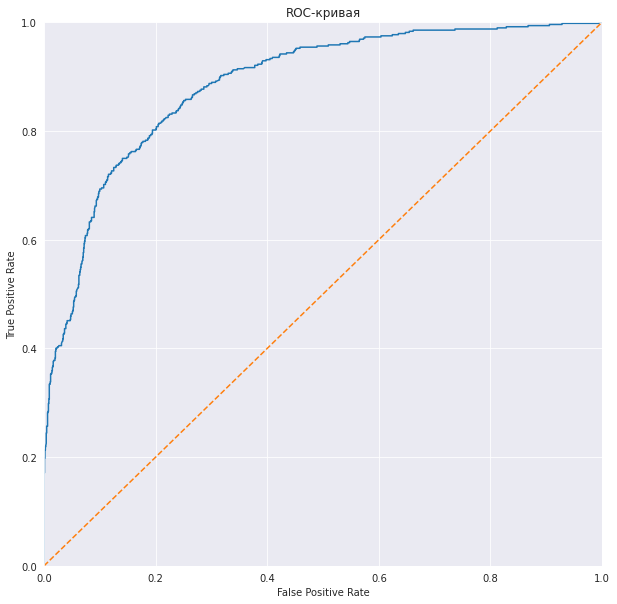

AUC: 0.8862367647106719


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print("AUC:", roc_auc_score(y_test, y_pred, average ='macro'))

Результат немного лучше, но модель лучше обобщается. Но в таком случае - лучше использовать базовую модель - быстрее время предсказаний

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Catboost базовый без преобразований

Аналогично попробуем Catboost - сначала базовый, затем на `StratifiedFolds`

In [ ]:
%%capture
train_X = features.copy()
train_X.drop('total_charges', axis=1, inplace=True)

In [ ]:
X_train , X_test , y_train , y_test, = train_test_split ( 
                                train_X, target, test_size=0.25, random_state=42)

In [ ]:
cat_features = list(X_train.select_dtypes(include=['object', 'category']).columns)

In [ ]:
X, X_val, y, y_val = train_test_split(X_train, y_train, 
                                      test_size=0.2, random_state=42)

In [ ]:
start = time.time()

train_data = Pool(data=X, 
                  label=y,
                  cat_features=cat_features)
valid_data = Pool(data=X_val, 
                  label=y_val,
                  cat_features=cat_features)
test_data = Pool(data=X_test,
                 cat_features=cat_features)

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 42
         }

model = CatBoostClassifier(**params)
model.fit(train_data,
          eval_set=valid_data, 
          use_best_model=True
          )
end = time.time()
elapsed = end - start

Learning rate set to 0.045236
0:	test: 0.8380834	best: 0.8380834 (0)	total: 57.2ms	remaining: 57.1s
200:	test: 0.8789463	best: 0.8789463 (200)	total: 1.08s	remaining: 4.31s
400:	test: 0.9041414	best: 0.9041775 (398)	total: 2.24s	remaining: 3.35s
600:	test: 0.9120521	best: 0.9124359 (586)	total: 3.41s	remaining: 2.27s
800:	test: 0.9175720	best: 0.9177842 (791)	total: 4.57s	remaining: 1.13s
999:	test: 0.9204256	best: 0.9205475 (982)	total: 5.72s	remaining: 0us

bestTest = 0.9205475184
bestIteration = 982

Shrink model to first 983 iterations.


In [ ]:
start_pred = time.time()
y_pred = model.predict_proba(X_test)[:, 1]

end_pred = time.time()
elapsed_pred = end_pred - start_pred

auc.append(roc_auc_score(y_test, y_pred, average ='macro'))
y_bin = (y_pred >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str(model.__class__.__name__)+str(' ')+str('базовый')))

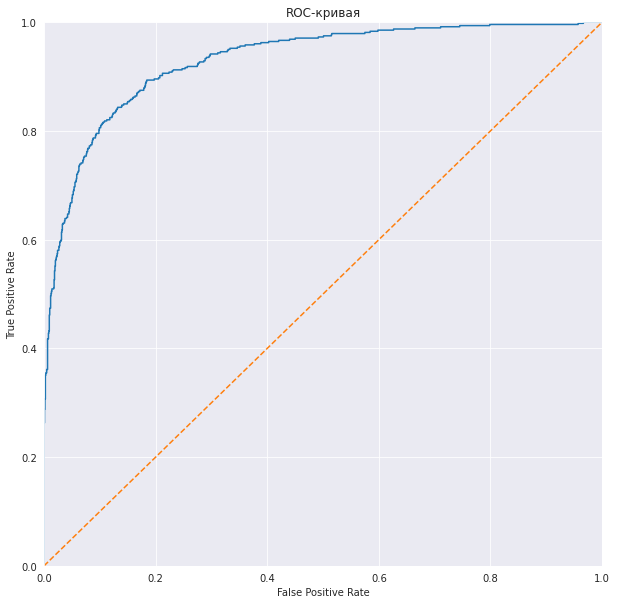

AUC: 0.9294421881259385


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print("AUC:", roc_auc_score(y_test, y_pred, average ='macro'))

`Catboost` показывает лучше результат чем `XGboost` на данном сете и он не требует преобразований для категориальных признаков, что экономит время

In [ ]:
fi = model.get_feature_importance(prettified=True)

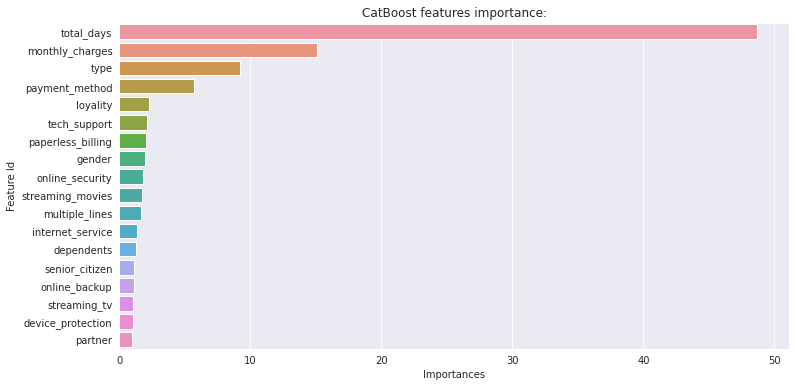

In [ ]:
plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=fi);
plt.title('CatBoost features importance:');

Сохраним наиболее важные признаки и попробуем построить модель только на базе них в [последствии](#shap)

In [ ]:
save_best = list(fi.loc[fi['Importances'] >= 1.5]['Feature Id'])

По признакам - все идентично `XGboost`, каких либо ярких изменений нет

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Catboost базовый без преобразований с кроссвалидацией

Посмотрим, какие результаты будут с `StratifiedKFold` при ансамблевом голосовании с кросс-валидацией

In [ ]:
%%time
start = time.time()

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

params_cat = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 42
         }

test_data = Pool(data=X_test,
                 cat_features=cat_features)
scores = []
prediction = np.zeros(X_test.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
    X_train_cat, X_valid_cat = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_cat, y_valid_cat = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    train_data = Pool(data=X_train_cat, 
                      label=y_train_cat,
                      cat_features=cat_features)
    valid_data = Pool(data=X_valid_cat, 
                      label=y_valid_cat,
                      cat_features=cat_features)
    
    model = CatBoostClassifier(**params_cat)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    score = model.get_best_score()['validation']['AUC']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred

prediction /= n_fold
end = time.time()
elapsed = end - start

Learning rate set to 0.045236
0:	test: 0.8192088	best: 0.8192088 (0)	total: 6.5ms	remaining: 6.49s
200:	test: 0.8751351	best: 0.8753290 (195)	total: 1.02s	remaining: 4.08s
400:	test: 0.8957712	best: 0.8958405 (397)	total: 2.14s	remaining: 3.2s
600:	test: 0.9057406	best: 0.9057406 (600)	total: 3.29s	remaining: 2.18s
800:	test: 0.9109516	best: 0.9109516 (800)	total: 4.43s	remaining: 1.1s
999:	test: 0.9133135	best: 0.9138214 (960)	total: 5.57s	remaining: 0us

bestTest = 0.9138214461
bestIteration = 960

Shrink model to first 961 iterations.
Learning rate set to 0.045236
0:	test: 0.8300302	best: 0.8300302 (0)	total: 6.29ms	remaining: 6.28s
200:	test: 0.8762872	best: 0.8762872 (200)	total: 1.02s	remaining: 4.05s
400:	test: 0.8953464	best: 0.8953464 (400)	total: 2.14s	remaining: 3.19s
600:	test: 0.9092385	best: 0.9092523 (598)	total: 3.31s	remaining: 2.2s
800:	test: 0.9127802	best: 0.9127802 (800)	total: 4.46s	remaining: 1.11s
999:	test: 0.9182013	best: 0.9184922 (988)	total: 5.61s	remaining

In [ ]:
auc.append(roc_auc_score(y_test, prediction, average ='macro'))
y_bin = (prediction >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed)
model_name.append((str(model.__class__.__name__)+str(' ')+str('CV')))

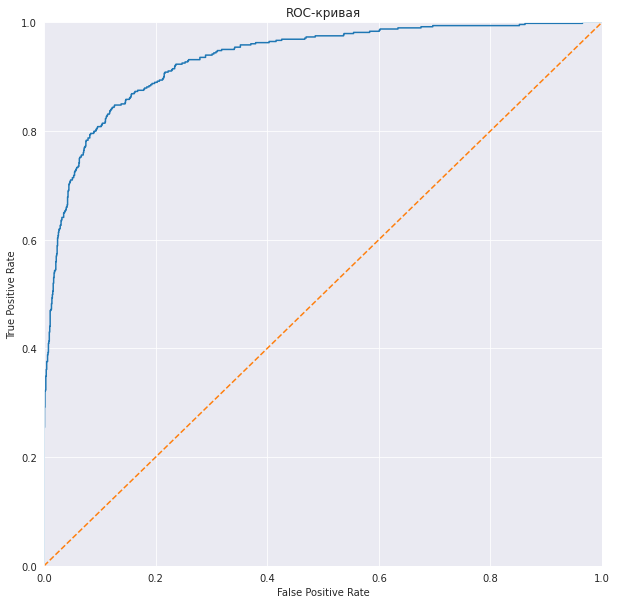

AUC: 0.9320990167372873


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, prediction) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print("AUC:", roc_auc_score(y_test, prediction, average ='macro'))

Мы смогли улучшить результат, достаточно значительно

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Xgboost тюнинг

Теперь попробуем настроить модели. Начнем с `XGboost`, использовать будем библиотеку `Optuna`

In [ ]:
def objective(trial,data=X_train_prep,target=y_train):
    
    train_x, test_x, train_y, test_y = train_test_split(X_train_prep, y_train, test_size=0.25,
                                                        random_state=42)
    param = {


        'alpha': trial.suggest_uniform('alpha', 15, 22),
        'gamma ': 0.1,
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 0.4),
        'subsample': trial.suggest_categorical('subsample', [0.7,0.8]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5]),
        'random_state': 42,
        'booster': 'gbtree',
        'n_jobs': 4
    }

    classes_weights = class_weight.compute_sample_weight(
                      class_weight=None,
                      y = train_y)
    model = XGBClassifier(**param, sample_weight=classes_weights)
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=50,verbose=False)
    preds = model.predict_proba(test_x)[:, 1]
    auc = roc_auc_score(test_y, preds, average ='macro')
    return auc


In [ ]:
%%capture
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)
print('Количество завершенных испытаний:', len(study.trials))
print('Лучшее испытание:', study.best_trial.params)

[I 2021-09-24 14:07:28,778] A new study created in memory with name: no-name-72e02f34-5c7b-49af-aaa6-8491b51a0175
[I 2021-09-24 14:07:29,185] Trial 0 finished with value: 0.865503712921903 and parameters: {'alpha': 19.94388489418295, 'colsample_bytree': 0.2327200058866627, 'subsample': 0.7, 'max_depth': 5}. Best is trial 0 with value: 0.865503712921903.
[I 2021-09-24 14:07:29,677] Trial 1 finished with value: 0.8728156275743607 and parameters: {'alpha': 15.316835268874748, 'colsample_bytree': 0.37843514569813796, 'subsample': 0.7, 'max_depth': 5}. Best is trial 1 with value: 0.8728156275743607.
[I 2021-09-24 14:07:29,995] Trial 2 finished with value: 0.8603915073119147 and parameters: {'alpha': 21.189726902992486, 'colsample_bytree': 0.253657910992114, 'subsample': 0.8, 'max_depth': 3}. Best is trial 1 with value: 0.8728156275743607.
[I 2021-09-24 14:07:30,371] Trial 3 finished with value: 0.8629826652410917 and parameters: {'alpha': 15.263584753095737, 'colsample_bytree': 0.1934705540

![](https://i.ibb.co/r455VWy/2021-09-23-17-07-03.png)

```
optuna.visualization.plot_optimization_history(study)```

Посмотрим как модель обобщается на тестовой выборке.
```Лучшее испытание: {'alpha': 18.14375210895344, 'colsample_bytree': 0.2931542828076106, 'subsample': 0.8, 'max_depth': 5}```

In [ ]:
params_XGB = study.best_trial.params

In [ ]:
%%time
start = time.time()
prediction = np.zeros(X_test_prep.shape[0])
n_fold = 5 
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42) 
rocauc_report = []
idx=0

for train_idx, test_idx in folds.split(X_train_prep, y_train):
    print("TRAIN:", len(train_idx), "TEST:", len(test_idx))
    X_train_fold, X_val_fold = X_train_prep.iloc[train_idx], X_train_prep.iloc[test_idx]
    y_tr_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
    classes_weights = class_weight.compute_sample_weight(
                      class_weight='balanced',
                      y = y_tr_fold)
    clone_clf = clone(XGBClassifier(**params_XGB, sample_weight=classes_weights,
                                    random_state=42,
                                    eval_metric ='logloss'))
    clone_clf.fit(X_train_fold, y_tr_fold, eval_set = [(X_val_fold, y_val_fold)],
              early_stopping_rounds=200, verbose=50)
    y_pred = clone_clf.predict_proba(X_test_prep)[:, 1]
    prediction += y_pred
    rocauc_report.append(roc_auc_score(y_val_fold, clone_clf.predict_proba(X_val_fold)[:, 1], average ='macro'))
    print(idx+1, rocauc_report[idx])
    idx +=1

prediction /= n_fold
end = time.time()
elapsed = end - start

TRAIN: 4225 TEST: 1057
[0]	validation_0-logloss:0.657653
Will train until validation_0-logloss hasn't improved in 200 rounds.
[50]	validation_0-logloss:0.374398
[99]	validation_0-logloss:0.35872
1 0.88259251392211
TRAIN: 4225 TEST: 1057
[0]	validation_0-logloss:0.656527
Will train until validation_0-logloss hasn't improved in 200 rounds.
[50]	validation_0-logloss:0.38156
[99]	validation_0-logloss:0.3641
2 0.880745467810604
TRAIN: 4226 TEST: 1056
[0]	validation_0-logloss:0.655618
Will train until validation_0-logloss hasn't improved in 200 rounds.
[50]	validation_0-logloss:0.367332
[99]	validation_0-logloss:0.351447
3 0.8883458785670693
TRAIN: 4226 TEST: 1056
[0]	validation_0-logloss:0.6598
Will train until validation_0-logloss hasn't improved in 200 rounds.
[50]	validation_0-logloss:0.410097
[99]	validation_0-logloss:0.404017
4 0.8496953080209354
TRAIN: 4226 TEST: 1056
[0]	validation_0-logloss:0.660129
Will train until validation_0-logloss hasn't improved in 200 rounds.
[50]	validation

In [ ]:
auc.append(roc_auc_score(y_test, prediction, average ='macro'))
y_bin = (prediction >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed)
model_name.append((str(clone_clf.__class__.__name__)+str(' ')+str('Optuna')))

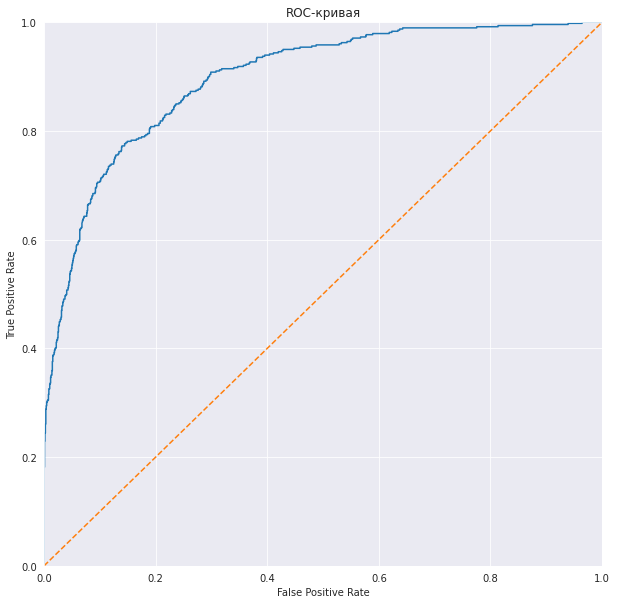

AUC: 0.8961613996918959


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, prediction) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print("AUC:", roc_auc_score(y_test, prediction, average ='macro'))

Результаты улучшили, относительно базового и результат удовлетворительный по качеству

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Catboost тюнинг

Аналогично, проведем испытания для `Catboost`

In [ ]:
cat_features

['type',
 'paperless_billing',
 'payment_method',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'multiple_lines',
 'loyality']

In [ ]:
def objective(trial,data=X_train,target=y_train):
    
    X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = train_test_split(X_train, y_train, test_size=0.25,
                                                        random_state=42)
    params_space = {

        
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1),
        'objective': 'Logloss',
        'depth': trial.suggest_int('depth', 2, 9),
        'boosting_type': 'Ordered',
        'bootstrap_type': 'MVS',
        'l2_leaf_reg': 1,
        'n_estimators': 200,
        'learning_rate':trial.suggest_float('learning_rate', 0.1, 0.4)
    }


    train_data = Pool(data=X_train_cat, 
                  label=y_train_cat,
                  cat_features=cat_features)
    valid_data = Pool(data=X_valid_cat, 
                      label=y_valid_cat,
                      cat_features=cat_features)

    model = CatBoostClassifier(**params_space, random_seed=42, verbose=False)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    preds = model.predict_proba(X_valid_cat)[:, 1]
    auc = roc_auc_score(y_valid_cat, preds, average ='macro')
    return auc


In [ ]:
%%capture
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15, timeout=600)
print('Количество завершенных испытаний:', len(study.trials))
print('Лучшее испытание:', study.best_trial.params)

[I 2021-09-24 14:07:37,781] A new study created in memory with name: no-name-fc377544-7d02-4aa6-909c-391099c0aadd
[I 2021-09-24 14:07:38,703] Trial 0 finished with value: 0.8716295958728434 and parameters: {'colsample_bylevel': 0.1326041193961982, 'depth': 4, 'learning_rate': 0.2750109563237555}. Best is trial 0 with value: 0.8716295958728434.
[I 2021-09-24 14:07:43,561] Trial 1 finished with value: 0.9308844407831314 and parameters: {'colsample_bylevel': 0.8485549691359667, 'depth': 8, 'learning_rate': 0.23317434806939202}. Best is trial 1 with value: 0.9308844407831314.
[I 2021-09-24 14:07:44,476] Trial 2 finished with value: 0.8847840312224307 and parameters: {'colsample_bylevel': 0.45431663894873486, 'depth': 3, 'learning_rate': 0.11064554824877967}. Best is trial 1 with value: 0.9308844407831314.
[I 2021-09-24 14:07:45,352] Trial 3 finished with value: 0.874095139607032 and parameters: {'colsample_bylevel': 0.1383112327857165, 'depth': 4, 'learning_rate': 0.37142456937916246}. Bes

![](https://i.ibb.co/cgVWTZB/2021-09-23-17-10-29.png)

```Лучшее испытание: {'colsample_bylevel': 0.996606644622792, 'depth': 9, 'learning_rate': 0.3497913137992659}```

```
optuna.visualization.plot_optimization_history(study)```

In [ ]:
params_cat_2 = study.best_trial.params

In [ ]:
%%time
start = time.time()

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)


test_data = Pool(data=X_test,
                 cat_features=cat_features)
scores = []
prediction = np.zeros(X_test.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
    X_train_cat, X_valid_cat = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_cat, y_valid_cat = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    train_data = Pool(data=X_train_cat, 
                      label=y_train_cat,
                      cat_features=cat_features)
    valid_data = Pool(data=X_valid_cat, 
                      label=y_valid_cat,
                      cat_features=cat_features)
    
    model = CatBoostClassifier(**params_cat_2, 
                               loss_function='Logloss',
                               eval_metric='AUC',
                               random_seed=42, 
                               verbose=200)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    score = model.get_best_score()['validation']['AUC']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred

prediction /= n_fold
end = time.time()
elapsed = end - start

0:	test: 0.8347355	best: 0.8347355 (0)	total: 9.82ms	remaining: 9.81s
200:	test: 0.8909850	best: 0.8939980 (153)	total: 1.76s	remaining: 6.99s
400:	test: 0.8898791	best: 0.8939980 (153)	total: 3.56s	remaining: 5.32s
600:	test: 0.8908303	best: 0.8939980 (153)	total: 5.32s	remaining: 3.53s
800:	test: 0.8896528	best: 0.8939980 (153)	total: 7.1s	remaining: 1.76s
999:	test: 0.8893712	best: 0.8939980 (153)	total: 8.77s	remaining: 0us

bestTest = 0.8939980237
bestIteration = 153

Shrink model to first 154 iterations.
0:	test: 0.8404545	best: 0.8404545 (0)	total: 9.72ms	remaining: 9.71s
200:	test: 0.9003634	best: 0.9021504 (186)	total: 1.75s	remaining: 6.95s
400:	test: 0.8986918	best: 0.9021504 (186)	total: 3.56s	remaining: 5.32s
600:	test: 0.8966924	best: 0.9021504 (186)	total: 5.34s	remaining: 3.54s
800:	test: 0.8944390	best: 0.9021504 (186)	total: 7.11s	remaining: 1.76s
999:	test: 0.8934508	best: 0.9021504 (186)	total: 8.82s	remaining: 0us

bestTest = 0.9021504234
bestIteration = 186

Shrin

In [ ]:
auc.append(roc_auc_score(y_test, prediction, average ='macro'))
y_bin = (prediction >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str(model.__class__.__name__)+str(' ')+str('Optuna')))

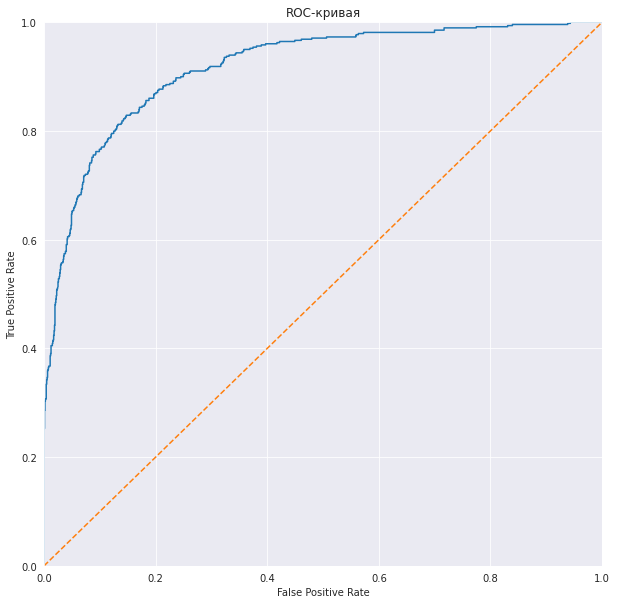

AUC: 0.9167630170760065


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, prediction)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print("AUC:", roc_auc_score(y_test, prediction, average ='macro'))

Результаты улучшили, относительно базового, но он не лучший. Стоит отметить, что модель хорошо обобщается

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Stacking

Попробуем улучшить результаты с помощью техники стэккинга. В качестве моделей возьмем те, что использовали ранее, мета-учеником сделаем неглубокую нейронную сеть

In [ ]:
def create_baseline():

	model = Sequential()
	model.add(Dense(8, input_dim=4, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', 
               optimizer=Nadam(lr=0.0001), 
               metrics=['accuracy'])
	return model

In [ ]:
blender = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=8, verbose=0)

In [ ]:
%%time
%%capture
start = time.time()
X_train_st, X_val_st, y_train_st, y_val_st = train_test_split(
        X_train_prep, y_train, test_size=0.25, random_state=42)
X, X_val_eval, y, y_val_eval = train_test_split(X_train_st, y_train_st, 
                                                test_size=0.20,
                                                random_state=42)
classes_weights = class_weight.compute_sample_weight(
                  class_weight='balanced',
                  y = y)

XGB_1 = XGBClassifier(random_state=42, eval_metric ='logloss',
                      sample_weight=classes_weights)
XGB_2 = XGBClassifier(**params_XGB, random_state=42, eval_metric ='logloss',
                      sample_weight=classes_weights)
CAT_1 = CatBoostClassifier(**params_cat)
CAT_2 = CatBoostClassifier(**params_cat_2)
estimators = [XGB_1, XGB_2, CAT_1, CAT_2]
#обучение моделей для сборки сета обучения мета-ученика
for estimator in estimators:
    print('Обучение', estimator)

    estimator.fit(X, y, eval_set=[(X_val_eval, y_val_eval)], verbose=200)

X_val_predictions = np.empty((X_val_st.shape[0], len(estimators)), dtype=np.float32)
#собираем сет из предсказний моделей
for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict_proba(X_val_st)[:, 1]

#учим мета-ученика
blender.fit(X_val_predictions, y_val_st)

end = time.time()
elapsed = end - start

Learning rate set to 0.042131
0:	test: 0.8188439	best: 0.8188439 (0)	total: 2.75ms	remaining: 2.75s
200:	test: 0.8709193	best: 0.8713267 (185)	total: 520ms	remaining: 2.06s
400:	test: 0.8928020	best: 0.8928274 (399)	total: 1.02s	remaining: 1.52s
600:	test: 0.9019014	best: 0.9025889 (588)	total: 1.52s	remaining: 1.01s
800:	test: 0.9054664	best: 0.9054749 (791)	total: 2.01s	remaining: 499ms
999:	test: 0.9051778	best: 0.9060097 (885)	total: 2.51s	remaining: 0us

bestTest = 0.9060096766
bestIteration = 885

Shrink model to first 886 iterations.
0:	learn: 0.5246461	test: 0.5186487	best: 0.5186487 (0)	total: 4.43ms	remaining: 4.42s
200:	learn: 0.0528717	test: 0.4168859	best: 0.3855054 (58)	total: 878ms	remaining: 3.49s
400:	learn: 0.0230816	test: 0.4535070	best: 0.3855054 (58)	total: 1.77s	remaining: 2.64s
600:	learn: 0.0140870	test: 0.4869656	best: 0.3855054 (58)	total: 2.64s	remaining: 1.75s
800:	learn: 0.0104319	test: 0.5130251	best: 0.3855054 (58)	total: 3.51s	remaining: 873ms
999:	learn

In [ ]:
start_pred = time.time()

X_test_predictions = np.empty((X_test.shape[0], len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict_proba(X_test_prep)[:, 1]

y_pred = blender.predict_proba(X_test_predictions)[:, 1]
end_pred = time.time()
elapsed_pred = end_pred - start_pred

In [ ]:
auc.append(roc_auc_score(y_test, y_pred, average ='macro'))
y_bin = (y_pred >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str(blender.__class__.__name__)+str(' ')+str('Stacking')))

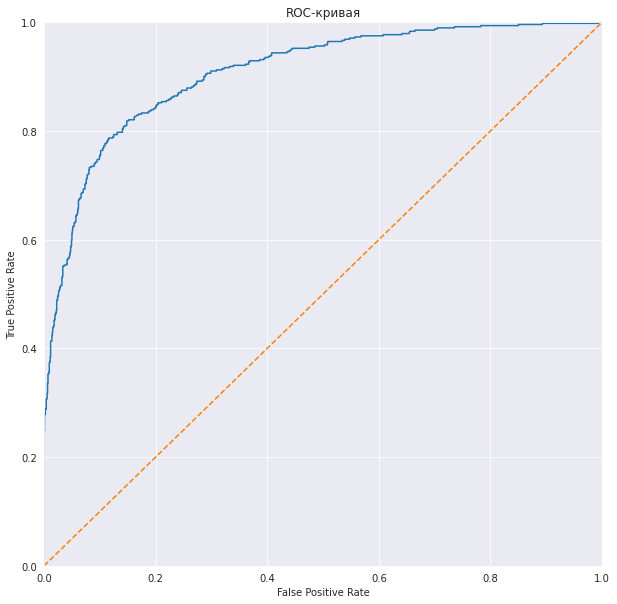

AUC: 0.9072609668478597


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print("AUC:", roc_auc_score(y_test, y_pred, average ='macro'))

Результаты приемлемы по качеству, но не лучшие - попробуем настроить мета-ученика. Модели уже настраивали ранее

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Stacking keras tuner

Попробуем настроить `Blender` с помощью `Keras Tuner`

In [ ]:
def build_model(hp):
  model = Sequential()
  activation_choice = hp.Choice('activation', values=['relu', 'selu', 'elu'])
  model.add(Dense(units=hp.Int('units_input',    
                                  min_value=4,    
                                  max_value=32,   
                                  step=2),  
                  input_dim=X_val_predictions.shape[1], activation=activation_choice))
  model.add(Dense(units=hp.Int('units_input',    
                              min_value=4,    
                              max_value=32,   
                              step=2),  
                  input_dim=X_val_predictions.shape[1], activation=activation_choice))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', 
                optimizer=Nadam(lr=0.001), 
                metrics=['accuracy'])
  return model

In [ ]:
tuner = RandomSearch(
    build_model,                 
    objective='loss',    
                        
    max_trials=10,                
    directory='test_directory_01',
    overwrite=True   
    )


early_stopping = EarlyStopping(

    mode='min', 
    patience=20,
    restore_best_weights=True,
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu', 'elu'], 'ordered': False}
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 32, 'step': 2, 'sampling': None}


In [ ]:
tuner.search(X_val_predictions, y_val_st,           
             batch_size=4,           
             epochs=20, validation_split=0.25
             )

Trial 10 Complete [00h 00m 11s]
loss: 0.34259140491485596

Best loss So Far: 0.339734822511673
Total elapsed time: 00h 01m 46s
INFO:tensorflow:Oracle triggered exit


In [ ]:
models = tuner.get_best_models(num_models=2)

```
for model in models:
  model.summary()
  model.evaluate(X_val_predictions, y_val_st)
  print()  
```

``` 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense (Dense)                (None, 28)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 28)                812       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 29        
=================================================================
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________
42/42 [==============================] - 0s 1ms/step - loss: 0.3504 - accuracy: 0.8607
```

Получили лучшие параметры из поиска - сформируем новую модель и попробуем запустить обучение еще раз

In [ ]:
def create_baseline():

	model = Sequential()
	model.add(Dense(28, input_dim=4, activation='selu'))
	model.add(Dense(28, activation='selu'))
	model.add(Dense(1, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', 
								optimizer=Nadam(lr=0.001), 
								metrics=['accuracy'])
	return model

In [ ]:
blender = KerasClassifier(build_fn=create_baseline, epochs=50, batch_size=4, verbose=0)

In [ ]:
%%time
%%capture
start = time.time()
X_train_st, X_val_st, y_train_st, y_val_st = train_test_split(
        X_train_prep, y_train, test_size=0.25, random_state=42)
X, X_val_eval, y, y_val_eval = train_test_split(X_train_st, y_train_st, 
                                                test_size=0.20,
                                                random_state=42)
classes_weights = class_weight.compute_sample_weight(
                  class_weight='balanced',
                  y = y)

XGB_1 = XGBClassifier(random_state=42, eval_metric ='logloss',
                      sample_weight=classes_weights)
XGB_2 = XGBClassifier(**params_XGB, random_state=42, eval_metric ='logloss',
                      sample_weight=classes_weights)
CAT_1 = CatBoostClassifier(**params_cat)
CAT_2 = CatBoostClassifier(**params_cat_2, 
                               loss_function='Logloss',
                              eval_metric='AUC',
                               random_seed=42, 
                               verbose=200)
estimators = [XGB_1, XGB_2, CAT_1, CAT_2]
for estimator in estimators:
    print('Обучение', estimator)

    estimator.fit(X, y, eval_set=[(X_val_eval, y_val_eval)], verbose=200)

X_val_predictions = np.empty((X_val_st.shape[0], len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict_proba(X_val_st)[:, 1]


blender.fit(X_val_predictions, y_val_st)

end = time.time()
elapsed = end - start

Learning rate set to 0.042131
0:	test: 0.8188439	best: 0.8188439 (0)	total: 2.54ms	remaining: 2.54s
200:	test: 0.8709193	best: 0.8713267 (185)	total: 525ms	remaining: 2.09s
400:	test: 0.8928020	best: 0.8928274 (399)	total: 1.02s	remaining: 1.53s
600:	test: 0.9019014	best: 0.9025889 (588)	total: 1.53s	remaining: 1.02s
800:	test: 0.9054664	best: 0.9054749 (791)	total: 2.03s	remaining: 505ms
999:	test: 0.9051778	best: 0.9060097 (885)	total: 2.52s	remaining: 0us

bestTest = 0.9060096766
bestIteration = 885

Shrink model to first 886 iterations.
0:	test: 0.8353705	best: 0.8353705 (0)	total: 4.47ms	remaining: 4.47s
200:	test: 0.8782022	best: 0.8839742 (74)	total: 899ms	remaining: 3.57s
400:	test: 0.8867159	best: 0.8882013 (365)	total: 1.79s	remaining: 2.67s
600:	test: 0.8864018	best: 0.8882013 (365)	total: 2.66s	remaining: 1.77s
800:	test: 0.8838044	best: 0.8882013 (365)	total: 3.54s	remaining: 879ms
999:	test: 0.8832866	best: 0.8882013 (365)	total: 4.4s	remaining: 0us

bestTest = 0.88820134

In [ ]:
start_pred = time.time()

X_test_predictions = np.empty((X_test.shape[0], len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict_proba(X_test_prep)[:, 1]

y_pred = blender.predict_proba(X_test_predictions)[:, 1]
end_pred = time.time()
elapsed_pred = end_pred - start_pred

In [ ]:
auc.append(roc_auc_score(y_test, y_pred, average ='macro'))
y_bin = (y_pred >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str(blender.__class__.__name__)+str(' ')+str('KerasTuner')))

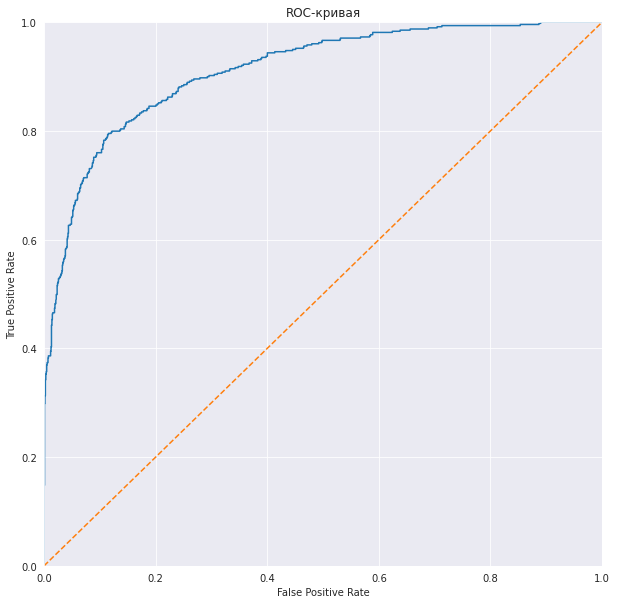

AUC: 0.911244174192855


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print("AUC:", roc_auc_score(y_test, y_pred, average ='macro'))

К сожалению, не удалось сильно улучшить результаты относительно общей картины, но лучше чем в базовом варианте

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Upsampling

Попробуем технику `upsampling`. Это позволит нам сбалансировать сет по количеству меток

In [ ]:
train, valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=42)

def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled = shuffle(features_upsampled, random_state=42)
    target_upsampled = shuffle(target_upsampled, random_state=42)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(train, target_train, 3)

print(features_upsampled.shape)
print(target_upsampled.shape)

(8062, 19)
(8062,)


Лучший баланс получился при использовании коэффициента повторной выборки, равного `3`

In [ ]:
target_upsampled.value_counts(normalize=True)

1    0.517241
0    0.482759
Name: label, dtype: float64

In [ ]:
%%time
start = time.time()

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

params_cat = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 42
         }

test_data = Pool(data=valid,
                 cat_features=cat_features)
scores = []
prediction = np.zeros(X_test.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(features_upsampled, target_upsampled)):
    X_train_cat, X_valid_cat = features_upsampled.iloc[train_index], features_upsampled.iloc[valid_index]
    y_train_cat, y_valid_cat = target_upsampled.iloc[train_index], target_upsampled.iloc[valid_index]
    
    train_data = Pool(data=X_train_cat, 
                      label=y_train_cat,
                      cat_features=cat_features)
    valid_data = Pool(data=X_valid_cat, 
                      label=y_valid_cat,
                      cat_features=cat_features)
    
    model = CatBoostClassifier(**params_cat)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    score = model.get_best_score()['validation']['AUC']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred

prediction /= n_fold
end = time.time()
elapsed = end - start

Learning rate set to 0.050217
0:	test: 0.8160473	best: 0.8160473 (0)	total: 9.19ms	remaining: 9.18s
200:	test: 0.8949477	best: 0.8949477 (200)	total: 1.59s	remaining: 6.32s
400:	test: 0.9241149	best: 0.9241149 (400)	total: 3.2s	remaining: 4.78s
600:	test: 0.9428470	best: 0.9428470 (600)	total: 4.84s	remaining: 3.22s
800:	test: 0.9537908	best: 0.9537908 (800)	total: 6.48s	remaining: 1.61s
999:	test: 0.9606525	best: 0.9606525 (999)	total: 8.09s	remaining: 0us

bestTest = 0.9606525306
bestIteration = 999

Learning rate set to 0.050217
0:	test: 0.8256904	best: 0.8256904 (0)	total: 8.79ms	remaining: 8.78s
200:	test: 0.9068450	best: 0.9068450 (200)	total: 1.57s	remaining: 6.24s
400:	test: 0.9392214	best: 0.9392214 (400)	total: 3.19s	remaining: 4.77s
600:	test: 0.9549590	best: 0.9549590 (600)	total: 4.84s	remaining: 3.21s
800:	test: 0.9643128	best: 0.9643128 (800)	total: 6.48s	remaining: 1.61s
999:	test: 0.9699770	best: 0.9699770 (999)	total: 8.12s	remaining: 0us

bestTest = 0.9699770351
best

In [ ]:
auc.append(roc_auc_score(target_valid, prediction, average ='macro'))
y_bin = (prediction >= 0.5)*1
accuracy.append(accuracy_score(target_valid, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed)
model_name.append((str(model.__class__.__name__)+str(' ')+str('CV-Upsampling')))

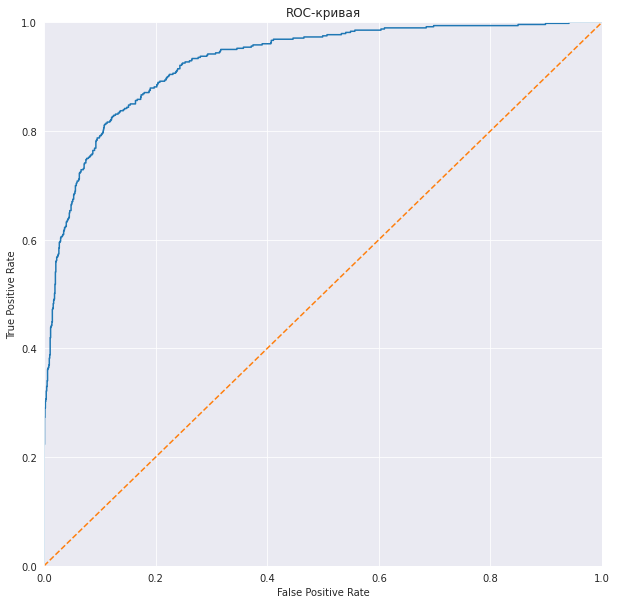

AUC: 0.92729018137761


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, prediction) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print("AUC:", roc_auc_score(y_test, prediction, average ='macro'))

Попробуем настроить. Модель плохо обобщается - идет значительное переобучение - но так или иначе - результат высокий

In [ ]:
def objective(trial,data=X_train,target=y_train):
    
    X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = train_test_split(features_upsampled, 
                                                                          target_upsampled, 
                                                                          test_size=0.25,
                                                                           random_state=42)
    params_space = {

        
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1),
        'objective': 'Logloss',
        'depth': trial.suggest_int('depth', 2, 9),
        'boosting_type': 'Ordered',
        'bootstrap_type': 'MVS',
        'l2_leaf_reg': 1,
        'n_estimators': 1000,
        'learning_rate':trial.suggest_float('learning_rate', 0.1, 0.4)
    }


    train_data = Pool(data=X_train_cat, 
                  label=y_train_cat,
                  cat_features=cat_features)
    valid_data = Pool(data=X_valid_cat, 
                  label=y_valid_cat,
                  cat_features=cat_features)

    model = CatBoostClassifier(**params_space, random_seed=42, verbose=False)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    preds = model.predict_proba(X_valid_cat)[:, 1]
    auc = roc_auc_score(y_valid_cat, preds, average ='macro')
    return auc


In [ ]:
%%capture
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15, timeout=600)
print('Количество завершенных испытаний:', len(study.trials))
print('Лучшее испытание:', study.best_trial.params)

[I 2021-09-24 14:12:39,701] A new study created in memory with name: no-name-13020ed1-79c7-4e90-b3f8-f8cf869d538b
[I 2021-09-24 14:12:43,867] Trial 0 finished with value: 0.8787230376107175 and parameters: {'colsample_bylevel': 0.1289281401788572, 'depth': 2, 'learning_rate': 0.3244929278621881}. Best is trial 0 with value: 0.8787230376107175.
[I 2021-09-24 14:12:55,940] Trial 1 finished with value: 0.9604828981768231 and parameters: {'colsample_bylevel': 0.6469997096233778, 'depth': 6, 'learning_rate': 0.37571225648435336}. Best is trial 1 with value: 0.9604828981768231.
[I 2021-09-24 14:13:00,753] Trial 2 finished with value: 0.8985588876798928 and parameters: {'colsample_bylevel': 0.1637562627640941, 'depth': 3, 'learning_rate': 0.2409493808722561}. Best is trial 1 with value: 0.9604828981768231.
[I 2021-09-24 14:13:14,477] Trial 3 finished with value: 0.9516747330224955 and parameters: {'colsample_bylevel': 0.9510512720254015, 'depth': 6, 'learning_rate': 0.20786709107387866}. Best

![](https://i.ibb.co/RBRtQk5/2021-09-23-17-16-56.png)

```Лучшее испытание: {'colsample_bylevel': 0.6825083382369974, 'depth': 7, 'learning_rate': 0.3379913478668721}```

```
optuna.visualization.plot_optimization_history(study)```

In [ ]:
params_cat_2 = study.best_trial.params

In [ ]:
%%time
start = time.time()

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)


test_data = Pool(data=X_test,
                 cat_features=cat_features)
scores = []
prediction = np.zeros(X_test.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
    X_train_cat, X_valid_cat = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_cat, y_valid_cat = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    train_data = Pool(data=X_train_cat, 
                      label=y_train_cat,
                      cat_features=cat_features)
    valid_data = Pool(data=X_valid_cat, 
                      label=y_valid_cat,
                      cat_features=cat_features)
    
    model = CatBoostClassifier(**params_cat_2, 
                               loss_function='Logloss',
                               eval_metric='AUC',
                               random_seed=42, 
                               verbose=200,
                               boosting_type='Ordered',
                               bootstrap_type='MVS',
                               l2_leaf_reg= 1,
                               n_estimators= 1000)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    score = model.get_best_score()['validation']['AUC']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred

prediction /= n_fold
end = time.time()
elapsed = end - start

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	test: 0.7600918	best: 0.7600918 (0)	total: 5.61ms	remaining: 5.61s
200:	test: 0.9257026	best: 0.9261828 (196)	total: 2.89s	remaining: 11.5s
400:	test: 0.9243358	best: 0.9277528 (237)	total: 5.8s	remaining: 8.66s
600:	test: 0.9206648	best: 0.9277528 (237)	total: 8.71s	remaining: 5.78s
800:	test: 0.9215098	best: 0.9277528 (237)	total: 11.6s	remaining: 2.88s
999:	test: 0.9195842	best: 0.9277528 (237)	total: 14.4s	remaining: 0us

bestTest = 0.9277527913
bestIteration = 237

Shrink model to first 238 iterations.
0:	test: 0.7859805	best: 0.7859805 (0)	total: 5.61ms	remaining: 5.6s
200:	test: 0.9146064	best: 0.9147657 (186)	total: 2.74s	remaining: 10.9s
400:	test: 0.9237539	best: 0.9244974 (372)	total: 5.74s	remaining: 8.58s
600:	test: 0.9266192	best: 0.9267485 (599)	total: 8.73s	remaining: 5.79s
800:	test: 0.9228050	best: 0.9269470 (613)	total: 11.7s	remaining: 2.9s
999:	test: 0.9199329	best: 0.9269470 (613)	total: 14.6s	remaining: 0us

bestTest = 0.9269470175
bestIteration = 613

Shrink 

In [ ]:
auc.append(roc_auc_score(y_test, prediction, average ='macro'))
y_bin = (prediction >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str(model.__class__.__name__)+str(' ')+str('Optuna-Upsampling')))

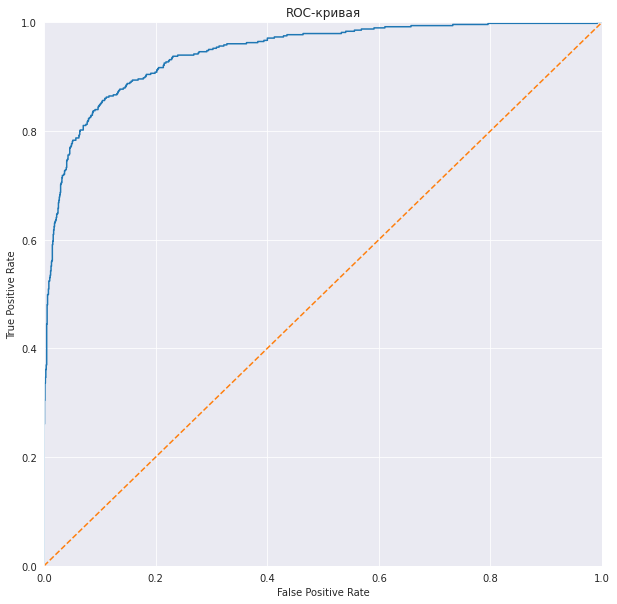

AUC: 0.9441601881194246


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, prediction)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print("AUC:", roc_auc_score(y_test, prediction, average ='macro'))

Получили очень высокий результат. Лучший на данный момент

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Ансамбль Логистической регрессии, Случайного леса и SVC

Попробуем ансамблевое предсказание, тип голосования выставим как soft. Использовать будем `Логистическую регрессию`, `Случайный лес` и `SVC опорные вектора`

In [ ]:
log_clf = LogisticRegression(solver="liblinear", random_state=42,
                            class_weight='balanced', max_iter=500)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42, 
                            class_weight='balanced')
svm_clf = SVC(gamma="auto", probability=True, random_state=42, 
                            class_weight='balanced')

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), 
                ('svc', svm_clf)],
    voting='soft')


start = time.time()
voting_clf.fit(X_train_prep, y_train)
end = time.time()
elapsed = end - start


In [ ]:
start_pred = time.time()
predict = voting_clf.predict_proba(X_test_prep)[:, 1]
end_pred = time.time()
elapsed_pred = end_pred - start_pred

In [ ]:
auc.append(roc_auc_score(y_test, predict, average ='macro'))
y_bin = (predict >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str(voting_clf.__class__.__name__)))

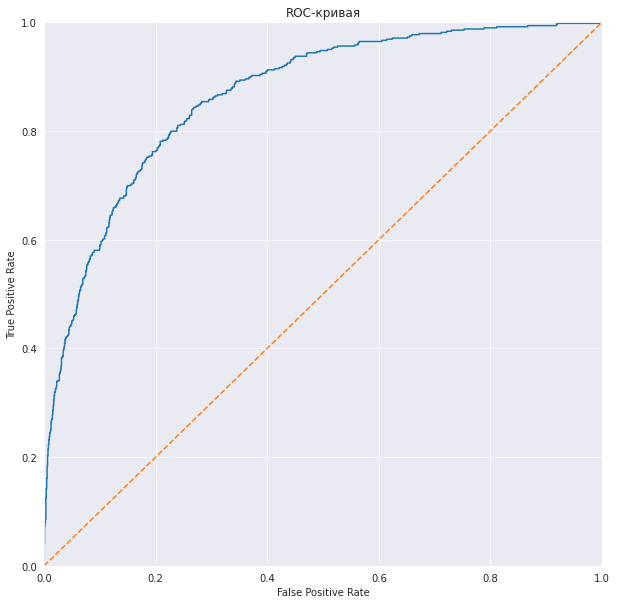

AUC: 0.8655586098182969


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, predict) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print("AUC:", roc_auc_score(y_test, predict, average ='macro'))

Результаты не самые лучшие, к сожалению. Настраивать ансамбль не будем - есть более простые способы получить требуемую метрику

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

<a id='shap'></a>

### Создание дополнительных признаков и обучение без наименее важных

Попробуем определить дополнительную категорию - только интернет пользователь или только пользователь телефона, или другой пользователь - например, только телевидение

In [ ]:
X_train.head()

,type,paperless_billing,payment_method,monthly_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,loyality,total_days
6607,Month-to-month,Yes,Electronic check,25.30,1,No,No,No,No,No,No,Male,0,No,Yes,No,0,31
2598,Month-to-month,Yes,Electronic check,75.15,1,No,No,Yes,No,No,No,Female,0,No,No,No,0,215
2345,Month-to-month,Yes,Bank transfer (automatic),20.05,0,No,No,No,No,No,No,Female,0,No,Yes,No,0,123
4093,Month-to-month,Yes,Credit card (automatic),76.00,1,No,No,No,No,No,No,Female,0,No,No,Yes,0,883
693,Month-to-month,Yes,Credit card (automatic),75.10,1,No,No,No,No,No,No,Female,0,No,No,Yes,0,92


In [ ]:
def users_bin (data):

    if data['internet_service'] == 1 and data['multiple_lines']=='Yes':
        return 0
    elif data['internet_service'] == 1:
        return 1
    elif data['multiple_lines']=='Yes':
        return 2
    else:
        return 3

In [ ]:
X_train['user_cat'] = X_train.apply(users_bin, axis=1)
X_test['user_cat'] = X_test.apply(users_bin, axis=1)

Удалим из обучабщей выборки признаки, что не вошли в лучшие

In [ ]:
cols_del = list(set(X_train.columns) - set(save_best))

In [ ]:
cols_del

['internet_service',
 'user_cat',
 'partner',
 'senior_citizen',
 'online_backup',
 'dependents',
 'streaming_tv',
 'device_protection']

In [ ]:
X_train.drop(cols_del, axis=1, inplace=True
             )
X_test.drop(cols_del, axis=1, inplace=True
             )
cat_features = list(X_train.select_dtypes(include=['object', 'category']).columns)

Попробуем обучить модель с новым признаком

In [ ]:
params_cat_2 = study.best_trial.params

In [ ]:
%%time
%%capture
start = time.time()

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)


test_data = Pool(data=X_test,
                 cat_features=cat_features)
scores = []
prediction = np.zeros(X_test.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
    X_train_cat, X_valid_cat = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_cat, y_valid_cat = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    train_data = Pool(data=X_train_cat, 
                      label=y_train_cat,
                      cat_features=cat_features)
    valid_data = Pool(data=X_valid_cat, 
                      label=y_valid_cat,
                      cat_features=cat_features)
    
    model = CatBoostClassifier(**params_cat_2, 
                               loss_function='Logloss',
                              eval_metric='AUC',
                               random_seed=42, 
                               verbose=200)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    score = model.get_best_score()['validation']['AUC']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred

prediction /= n_fold
end = time.time()
elapsed = end - start

0:	test: 0.8055822	best: 0.8055822 (0)	total: 6.91ms	remaining: 6.9s
200:	test: 0.8864875	best: 0.8893573 (141)	total: 1.23s	remaining: 4.9s
400:	test: 0.8897752	best: 0.8910774 (344)	total: 2.5s	remaining: 3.73s
600:	test: 0.8902116	best: 0.8910774 (344)	total: 3.73s	remaining: 2.48s
800:	test: 0.8893204	best: 0.8910774 (344)	total: 4.98s	remaining: 1.24s
999:	test: 0.8888263	best: 0.8910774 (344)	total: 6.17s	remaining: 0us

bestTest = 0.891077382
bestIteration = 344

Shrink model to first 345 iterations.
0:	test: 0.8176642	best: 0.8176642 (0)	total: 6.95ms	remaining: 6.94s
200:	test: 0.8850260	best: 0.8850260 (200)	total: 1.21s	remaining: 4.82s
400:	test: 0.8883784	best: 0.8884015 (398)	total: 2.44s	remaining: 3.64s
600:	test: 0.8894543	best: 0.8896344 (490)	total: 3.67s	remaining: 2.44s
800:	test: 0.8896898	best: 0.8902578 (738)	total: 4.94s	remaining: 1.23s
999:	test: 0.8905995	best: 0.8910751 (983)	total: 6.12s	remaining: 0us

bestTest = 0.8910750732
bestIteration = 983

Shrink m

In [ ]:
auc.append(roc_auc_score(y_test, prediction, average ='macro'))
y_bin = (prediction >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_bin))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str(model.__class__.__name__)+str(' ')+str('New_feature_shap')))

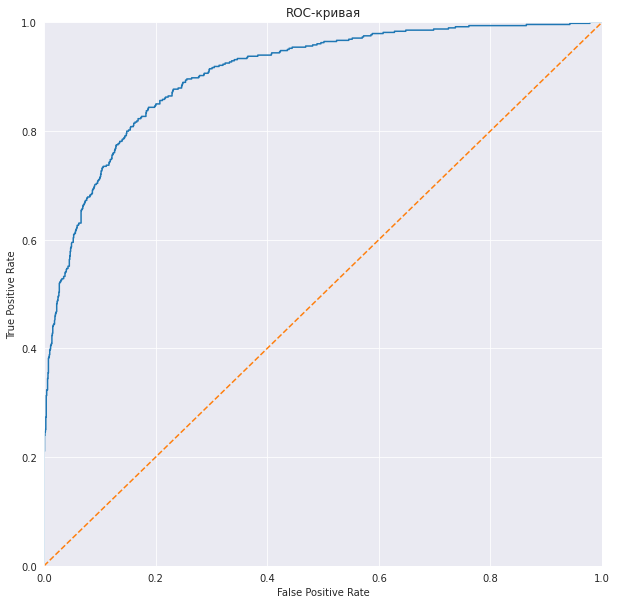

AUC: 0.9058116395637038


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, prediction)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print("AUC:", roc_auc_score(y_test, prediction, average ='macro'))

К сожалению, результат снова не улучшился значительно. Но и не стал сильно хуже - все еще приемлем - и это с уменьшением количества признаков почти в два раза

In [ ]:
print(f'{len(X_train.columns)} признаков вместо 19 начальных')

11 признаков вместо 19 начальных


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Проверка на адекатность. DummyClassifier

Попробуем стратегию `stratified`, нам важны `1` - они говорят об оттоке, предсказывать всем отток 1 как константу - повлечет за собой убытки компании, предсказывать `0` - мы не предскажем оттока. Либо просто предсказывать `0` и `1` с вероятностью `0.5`. Косвенно, через `ROC-AUC` мы уже проверяли производительность наших моделей - сделаем дополнительную проверку

In [ ]:
start = time.time()
model = DummyClassifier(strategy='stratified')
model.fit(X_train_prep, y_train)

end = time.time()
elapsed = end - start

In [ ]:
start_pred = time.time()
y_pred = model.predict_proba(X_test_prep)[:, 1]

end_pred = time.time()
elapsed_pred = end_pred - start_pred

auc.append(roc_auc_score(y_test, y_pred, average ='macro'))
y_bin = (y_pred >= 0.5)*1
accuracy.append(accuracy_score(y_test, y_pred))
training_time.append(elapsed)
prediction_time.append(elapsed_pred)
model_name.append((str(model.__class__.__name__)+str(' ')+str('stratified')))

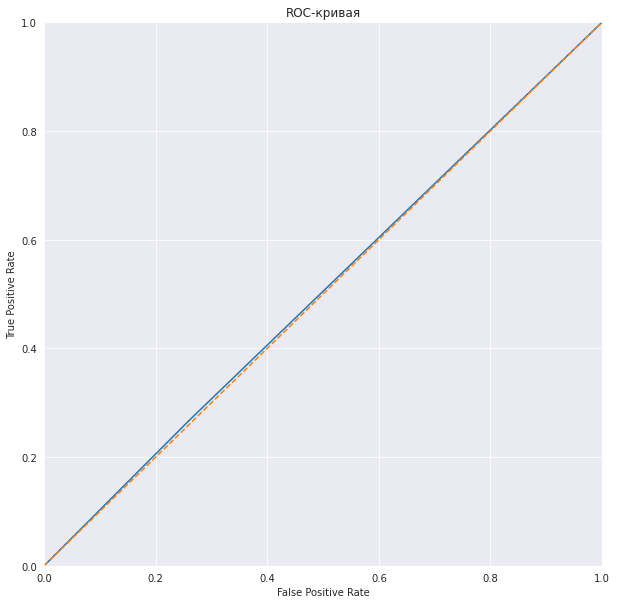

AUC: 0.5037364960151642


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


print("AUC:", roc_auc_score(y_test, y_pred, average ='macro'))

Получили вполне ожидаемый вариант - `AUC` близок к `0.5` - это можно было не делать - но для интерпритации `ROC-AUC` сделали дополнительную модель

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

## Отчет о работе

Для удобства - выведем сводную таблицу

In [ ]:
summary = pd.DataFrame({ 
    'model' : model_name , 
    'training_time, sec' : training_time ,
    'prediction_time, sec' : prediction_time , 
    'AUC' : auc,
    'Accuracy': accuracy}
    ).sort_values(by='AUC', ascending=False).reset_index(drop=True)


summary['Качество'] = summary['AUC'].apply(lambda x:'Удовлетворительное' if x >= 0.88 else 'Неудовлетворительное')


summary.style.highlight_max( 'AUC' , color = 'green' , axis = 0 )

,model,"training_time, sec","prediction_time, sec",AUC,Accuracy,Качество
0,CatBoostClassifier Optuna-Upsampling,73.177123,0.131567,0.944160,0.897217,Удовлетворительное
1,CatBoostClassifier CV,28.790407,28.790407,0.932099,0.877910,Удовлетворительное
2,CatBoostClassifier базовый,5.907951,0.014036,0.929442,0.873935,Удовлетворительное
3,CatBoostClassifier CV-Upsampling,41.238677,41.238677,0.927290,0.858603,Удовлетворительное
4,CatBoostClassifier Optuna,44.950295,0.014036,0.916763,0.861442,Удовлетворительное
5,KerasClassifier KerasTuner,25.197979,0.131567,0.911244,0.867121,Удовлетворительное
6,LightGBM GridSearCVcategory,0.550743,0.328969,0.910374,0.836457,Удовлетворительное
7,KerasClassifier Stacking,29.684688,0.150840,0.907261,0.851221,Удовлетворительное
8,CatBoostClassifier New_feature_shap,31.494872,0.467203,0.905812,0.852357,Удовлетворительное
9,XGBClassifier Optuna,2.464332,2.464332,0.896161,0.834753,Удовлетворительное


Оператор связи хочет научиться прогнозировать отток клиентов. В результате проведенных иследований, выяснилось:  

**Компанию покидают чаще всего прибыльные пользователи, что используют:**

- электронные чеки
- используют помесячную оплату
- не используют дополнительные услуги в виде антивируса, облачного хранилища, выделенной линии с технической поддержкой и защиты оборудования
- не состоят в браке. 

**Чем выше помесячная оплата** - **тем выше вероятность ухода**. Возможно, стоит рассмотреть необходимость стимуляции для перехода на более выгодные тарифы


Данные исследования подтвердились также выводами моделей на важности признаков.  

По результатам работы быи выполнены все запланированные пункта плана:

1.  Нами был подготовлен черновой `pipeline` загрузки сета данных, `Pipeline` обработки признаков - это позволит в дальнейшем автоматизировать процесс обработки новой информаци. Pipeline подготовки признаков позволяет провести кодирование категориальных переменных, стандартизировать количественные, в связи с их не нормально распределенной природой.

2. Столкнулись с дисбалансом классов - исправили данную проблему, используя взвешивание во время обучения, применяй перекрестную валидацию с стратифицированным делением выборки, также опрабовали технику `Upsampling`

3. Создали дополнительный признак - количество дней в качестве клиента. Брать дату начала и конца не стали - чтобы уменьшить вероятность `Data leaks`. Измерения взаимной информации показало, что новый признак имеет `0.3п` взаимной информации и будет приемлемым для обработки. Также добавили кластеры пользователей в зависимости от размера месячной оплаты.

4. Была обнаружена сильная корреляция между количеством дней и общим платежей - признак `total_charges` - был удален

5. Выяснили, что удалив следуующие признаки`user_cat`, `streaming_tv`,  `online_backup`,  `senior_citizen`,  `device_protection`,  `dependents`,  `partner`,  `internet_service` - удается получить достаточно высокий результат. Это позволит сократить время сборы информации

Целевой метрикой обозначили - `AUC-ROC`. Лучше себя показала по соотношения времени предсказания и метрики, модель на базе `CatBoostClassifier Optuna-Upsampling` с настройкой с помощью `Optuna` и техникой `upsampling` и очень хорошо себя показал базовый `CatBoostClassifier Optuna`, настроенный Optuna

Стоит отметить, что наиболее важные признаки - в**ремя, в качестве клиента, ежемесячная оплата, тип договора (особенно помесячный), выделенная линия технической поддержки, платежный метод**

Если результаты будут считаться приемлемыми - необходимо добавить больше данных для обучения моделей, чтобы улучшить обобщение, проработать `Pipeline` для обучения моделей, помимо обработки и получения предсказаний. на данный момент, лучший выбор по соотношению времени обучения, предсказания и значения метрик - `CatBoostClassifier Optuna-Upsampling` с настройкой с помощью `Optuna` и техникой `upsampling` или `CatBoostClassifier Optuna` (для удобства воспрития модели приведены в сводной таблице выше)

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___